# Overview:

* AlexNet Training
* Saved models + saved tensors
* With tensor tools integration
* Streamlined workflow
* 3D neuron tensor
* 2D neuron tensor

References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet

https://www.kaggle.com/asilvaigor/learning-alexnet

https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3?u=klory

https://distill.pub/2017/feature-visualization/

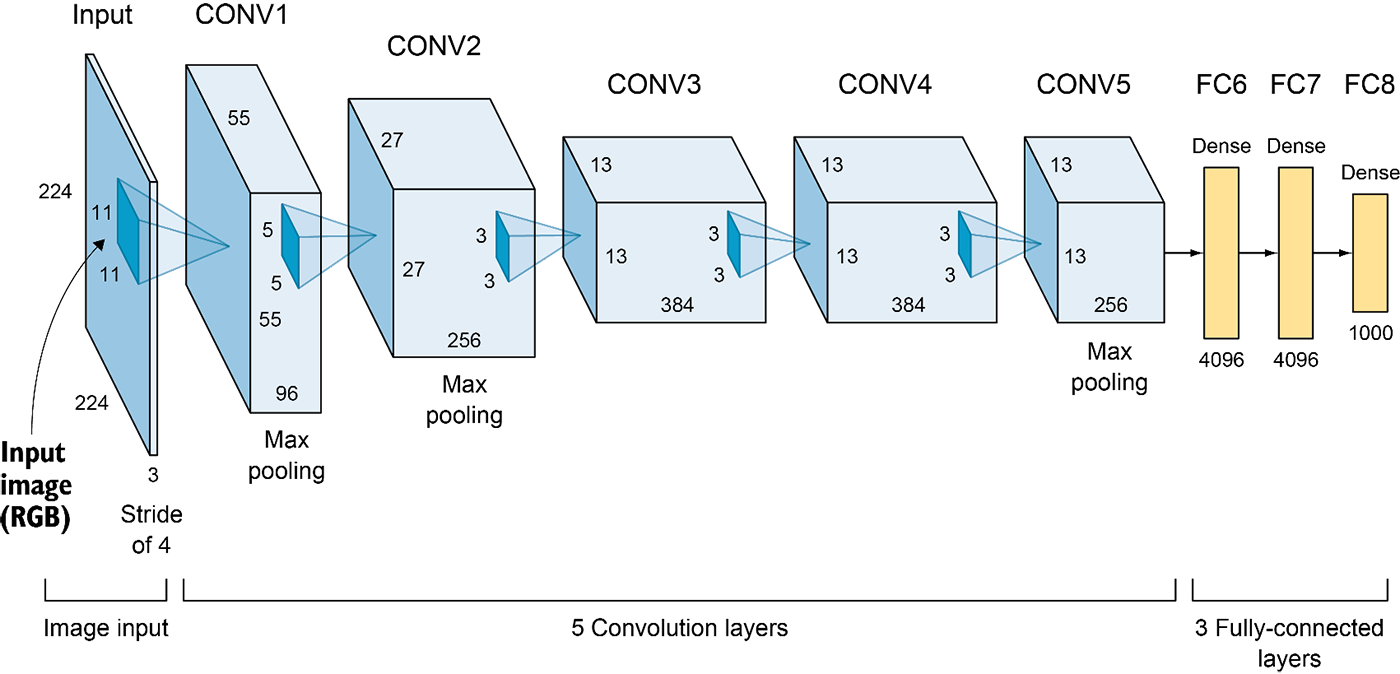

Note that in pytorch linear laryers are initialized in this way:

```
stdv = 1. / math.sqrt(self.weight.size(1))
self.weight.data.uniform_(-stdv, stdv)
if self.bias is not None:
    self.bias.data.uniform_(-stdv, stdv)
```



In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime
from scipy.io import savemat
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
import time

In [2]:
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.8.0
numpy Version: 1.21.5


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.optim as optim

print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [4]:
!pip install git+https://github.com/ahwillia/tensortools
import tensortools as tt
from scipy.ndimage import gaussian_filter

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-oxj9ktfx
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-oxj9ktfx
  Created wheel for tensortools: filename=tensortools-0.3-py3-none-any.whl size=47993 sha256=5bc0b87f39c1b680ab90a384ac1f30e72529a9e95b537867f2b78baa18f50c9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-40rjdu5u/wheels/1c/a5/81/96b292bf9d9e3e00a29f59864a212f082de8221f254a82e159
Successfully built tensortools


# Set seed for reporducibility:

In [5]:
import numpy as np
import torch
import random 
import os

default_seed = 4142 
def seed_everything(seed = 1234):
  random.seed(seed)
  tseed = random.randint(1,1E6)
  tcseed = random.randint(1,1E6)
  npseed = random.randint(1,1E6)
  ospyseed = random.randint(1,1E6)
  torch.manual_seed(tseed)
  torch.cuda.manual_seed_all(tcseed)
  np.random.seed(npseed)
  os.environ['PYTHONHASHSEED'] = str(ospyseed)

seed_everything(default_seed)

# Load CIFAR-10 data:

In [6]:
transform = transforms.Compose([
    transforms.Resize(128),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=False, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
train_data[1][0]

tensor([[[ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.4851,  0.4851,  0.4508,  ..., -0.7650, -0.7822, -0.7822],
         ...,
         [ 0.6734,  0.6734,  0.6563,  ...,  0.2967,  0.3138,  0.3138],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309]],

        [[ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0280,  1.0280,  0.9405,  ..., -0.6176, -0.6352, -0.6352],
         ...,
         [ 0.5728,  0.5728,  0.5728,  ...,  0.2577,  0.2752,  0.2752],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927]],

        [[ 1.4548,  1.4548,  1.3502,  ..., -0.5844, -0.5844, -0.5844],
         [ 1.4548,  1.4548,  1.3502,  ..., -0

In [9]:
N_train = 50000
N_test = 10000
img_shape = (3, 32, 32) #use a tuple in the fomat: (n_channels, height, width)
n_classes = 10
print(N_train,N_test,img_shape,n_classes)

50000 10000 (3, 32, 32) 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


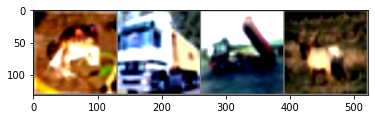

 Frog Truck Truck  Deer


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define AlexNet Model:

In [11]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [12]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:

print(device)

cuda:0


In [16]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

# Train and save model:

In [17]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Embeddings/code'

Mounted at /content/drive/
/content/drive/My Drive/Embeddings/code


In [ ]:
# torch.save({
#             'epoch': epoch + 1,
#             'state_dict': AlexNet_Model.state_dict(),
#             'optimizer' : optimizer.state_dict(),
#             }, '/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch10_alt.pt')

In [ ]:
# AlexNet_Model_epoch10_alt = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch10_alt.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch10_alt.pt')['state_dict'])
# AlexNet_Model_epoch10_alt.to(device)

# Load saved models for epochs 0, 1, 5, 10, 15, 20, 25:

In [18]:
AlexNet_Model_epoch0 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch0.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch0.pt'))
AlexNet_Model_epoch0.to(device)

# AlexNet_Model_epoch1 = AlexNest(num_classes=10, downscale=2)
# AlexNet_Model_epoch1.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch1.pt'))
# AlexNet_Model_epoch1.to(device)

# AlexNet_Model_epoch2 = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch2.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch2.pt'))
# AlexNet_Model_epoch2.to(device)

# AlexNet_Model_epoch3 = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch3.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch3.pt'))
# AlexNet_Model_epoch3.to(device)

# AlexNet_Model_epoch4 = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch4.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch4.pt'))
# AlexNet_Model_epoch4.to(device)

AlexNet_Model_epoch5 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch5.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch5.pt'))
AlexNet_Model_epoch5.to(device)

# AlexNet_Model_epoch6 = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch6.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch6.pt'))
# AlexNet_Model_epoch6.to(device)

AlexNet_Model_epoch7 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch7.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch7.pt'))
AlexNet_Model_epoch7.to(device)

# AlexNet_Model_epoch9 = AlexNet(num_classes=10, downscale=2)
# AlexNet_Model_epoch9.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch9.pt'))
# AlexNet_Model_epoch9.to(device)

AlexNet_Model_epoch10 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch10.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch10.pt'))
AlexNet_Model_epoch10.to(device)

AlexNet_Model_epoch12 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch12.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch12.pt'))
AlexNet_Model_epoch12.to(device)

FileNotFoundError: ignored

In [ ]:
device

In [ ]:
AlexNet_Model_epoch16 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch16.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch16.pt')['state_dict'])
AlexNet_Model_epoch16.to(device)


# Load saved tensors:

In [ ]:
# N_epoch0_fix = loadmat("neuron_output_3D_epoch0_fix_debugged.mat")['neuron_output_3D']
# N_epoch5_fix = loadmat("neuron_output_3D_epoch5_fix_debugged.mat")['neuron_output_3D']
N_epoch7_fix_conv1 = loadmat("neuron_output_3D_epoch7_fix_conv1.mat")['neuron_output_3D']
N_epoch10_fix_conv1 = loadmat("neuron_output_3D_epoch10_fix_conv1.mat")['neuron_output_3D']
N_epoch12_fix_conv1 = loadmat("neuron_output_3D_epoch12_fix_conv1.mat")['neuron_output_3D']
N_epoch16_max10_conv1 = loadmat("neuron_output_3D_epoch16_max_conv1.mat")['neuron_output_3D']

N_epoch10_max_conv1 = loadmat("neuron_output_3D_epoch10_max_conv1.mat")['neuron_output_3D']

# N_epoch0_fix_2D = loadmat("neuron_output_2D_epoch0_fix_debugged.mat")['neuron_output_2D']
# N_epoch5_fix_2D = loadmat("neuron_output_2D_epoch5_fix_debugged.mat")['neuron_output_2D']
# N_epoch7_fix_2D = loadmat("neuron_output_2D_epoch7_fix_debugged.mat")['neuron_output_2D']
# N_epoch12_fix_2D = loadmat("neuron_output_2D_epoch12_fix_debugged.mat")['neuron_output_2D']
# N_epoch16_max10_2D = loadmat("neuron_output_2D_epoch16_max10_debugged.mat")['neuron_output_2D']

Plots during meeting! (for the updated plots, please refer to section "streamline")

In [ ]:
tensor_factors = ensembles['ncp_hals'].results[50][0].factors[0]

In [ ]:
tensor_factors.shape

In [ ]:
plt.plot(tensor_factors[:,0])

In [ ]:
for i in range(11):
  factor = tensor_factors[:,i]
  feature_map_side = 11 
  vmin = factor.min()
  vmax = factor.max()
  f, axes = plt.subplots(1,10,figsize=(10,1))
  for f_i, ax in enumerate(axes):
    feature_map_matrix = factor[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].reshape((feature_map_side, feature_map_side))
    ax.imshow(feature_map_matrix, vmin = vmin, vmax = vmax)
    ax.set(xticks = [], yticks = [])
  plt.show()

In [ ]:
N.shape

In [ ]:
factor = tensor_factors[:,0]

In [ ]:
factor.shape

(1210,)

In [ ]:
f_i = 0
im_i = 0

In [ ]:
neuron_matrix = N[:,im_i,:]

In [ ]:
neuron_matrix_fi =  neuron_matrix[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)]

In [ ]:
neuron_matrix_fi.shape

(121, 1024)

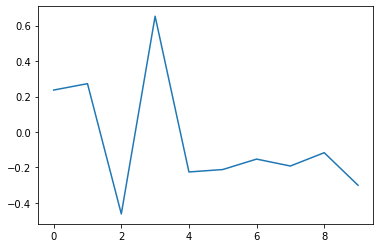

In [ ]:
n_feature_maps = 10
feature_map_side = 11
plt.plot([neuron_matrix[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].mean() for f_i in range(n_feature_maps)])

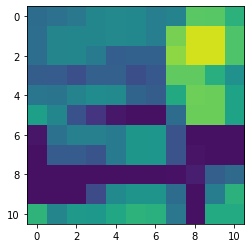

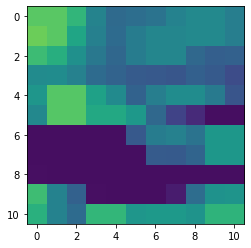

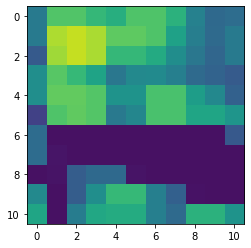

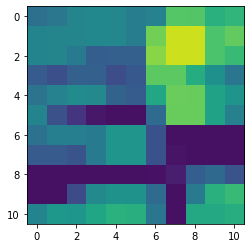

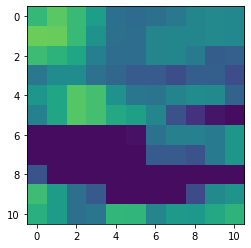

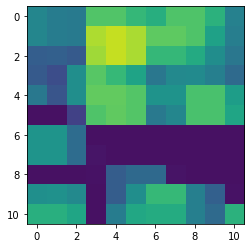

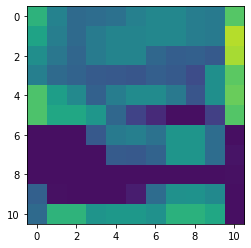

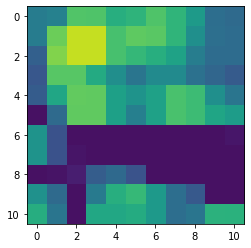

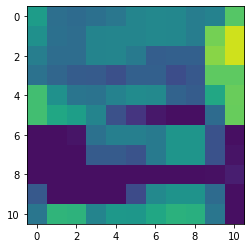

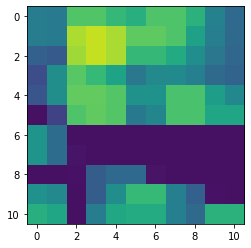

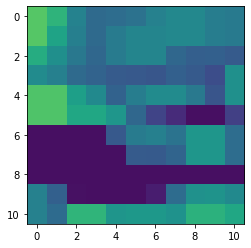

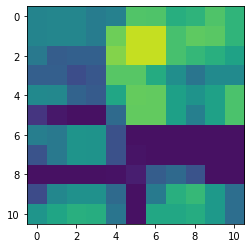

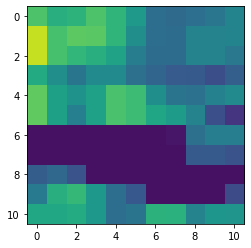

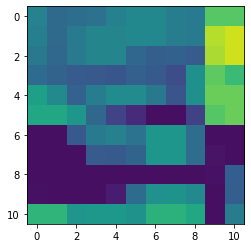

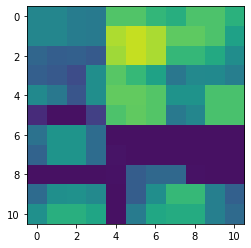

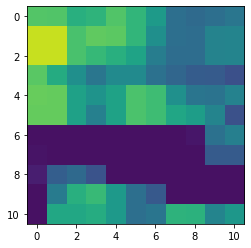

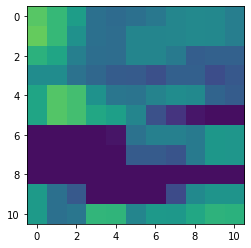

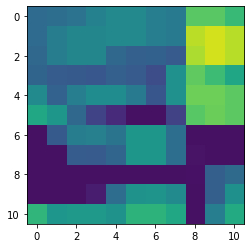

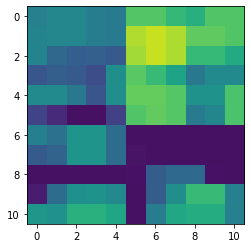

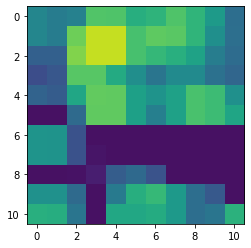

In [ ]:
neuron_matrix = N[:,im_i,:]
neuron_matrix_fi =  neuron_matrix[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)]
vmin = neuron_matrix_fi.min()
vmax = neuron_matrix_fi.max()
N_frames = 20
for t in range(1000, N_frames + 1000):
  neuron_matrix_fi_t = neuron_matrix_fi[:, t].reshape((feature_map_side, feature_map_side))
  plt.imshow(neuron_matrix_fi_t, vmin = vmin, vmax = vmax)
  plt.show()

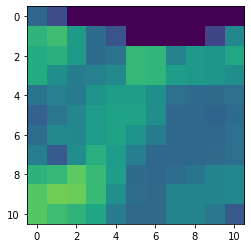

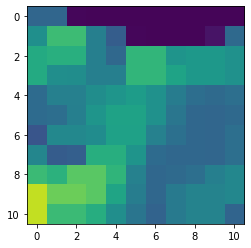

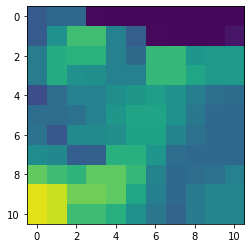

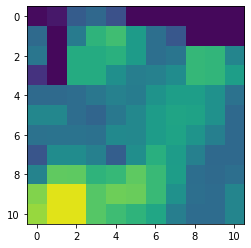

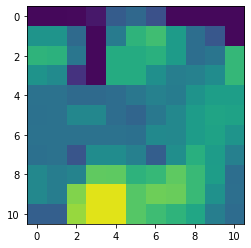

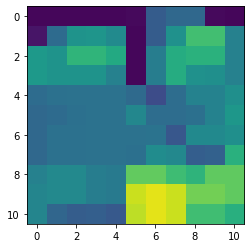

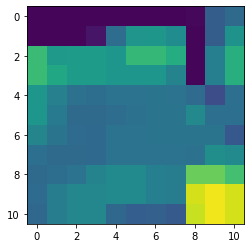

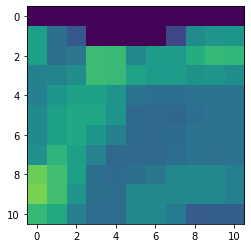

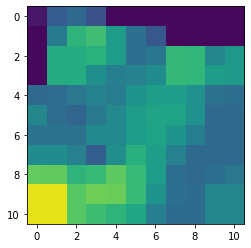

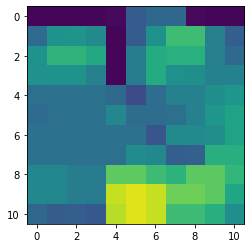

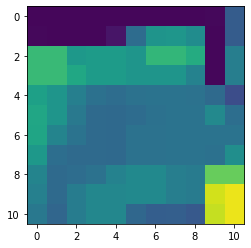

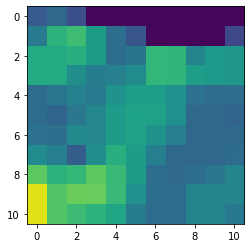

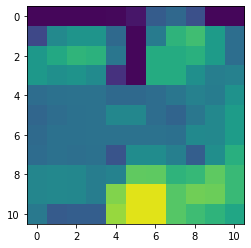

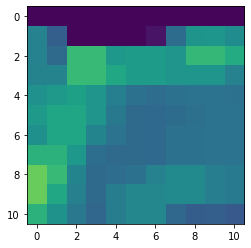

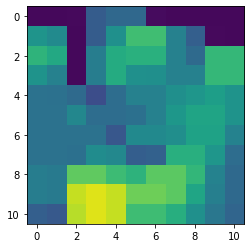

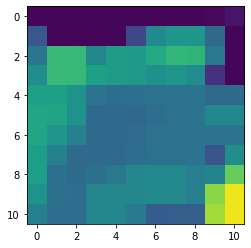

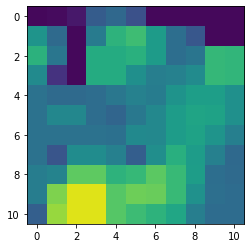

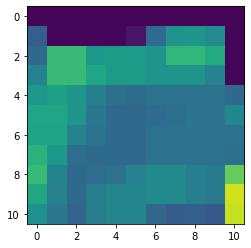

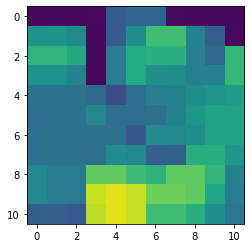

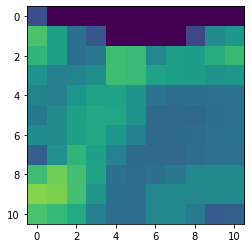

In [ ]:
vmin = neuron_matrix_fi.min()
vmax = neuron_matrix_fi.max()
N_frames = 20
for t in range(1000, N_frames + 1000):
  neuron_matrix_fi_t = neuron_matrix_fi[:, t].reshape((feature_map_side, feature_map_side))
  plt.imshow(neuron_matrix_fi_t, vmin = vmin, vmax = vmax)
  plt.show()

# Streamline:

In [ ]:
N_epoch16_max10_conv1.shape

(605, 10, 1024)

In [ ]:
def get_tensor_factors(N, dim = 3, n_vertical_shifts = 32, ranks = [10, 50, 100], reps = 5):
## note that for 2D tensor (ie a matrix), rank + nullity = num_columns => rank <= num_columns
  if dim == 3:
    N_filtered = np.empty(N.shape)
    for i in range(N.shape[0]):
      for j in range(N.shape[1]):
        filtered = gaussian_filter(N[i,j,:].reshape((n_vertical_shifts, n_vertical_shifts)), sigma=1).reshape((n_vertical_shifts * n_vertical_shifts,))
        N_filtered[i,j,:] = filtered[:]
  else:
    N_filtered = N.reshape((N.shape[0], N.shape[1], 1))

  # Fit ensembles of tensor decompositions:
  methods = (
    'ncp_hals',  # fits nonnegative tensor decomposition.
  )

  ensembles = {}
  for m in methods:
      ensembles[m] = tt.Ensemble(fit_method=m,  fit_options=dict(tol=1e-5))
      ensembles[m].fit(N_filtered, ranks=ranks, replicates=reps)
      ## replicates: int, number of models to fit at each rank

  ## plot objective, similarity, factors:
  """
  Customized plotting routines for CP decompositions
  """

  # Plotting options for the unconstrained and nonnegative models.
  plot_options = {
    'ncp_hals': {
      'line_kw': {
        'color': 'blue',
        'alpha': 1,
        'label': 'ncp_hals',
      },
      'scatter_kw': {
        'color': 'blue',
        'alpha': 1,
        's': 1,
      },
    },
  }

  def plot_objective(ensemble, partition='train', ax=None, jitter=0.1,
                    scatter_kw=dict(), line_kw=dict()):
      """Plots objective function as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      partition : string, one of: {'train', 'test'}
          specifies whether to plot the objective function on the training
          data or the held-out test set.
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      """

      if ax is None:
          ax = plt.gca()

      if partition == 'train':
          pass
      elif partition == 'test':
          raise NotImplementedError('Cross-validation is on the TODO list.')
      else:
          raise ValueError("partition must be 'train' or 'test'.")

      # compile statistics for plotting
      x, obj, min_obj = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          o = ensemble.objectives(rank)
          obj.extend(o)
          x.extend(np.full(len(o), rank))
          min_obj.append(min(o))

      print(o)
      print(obj)
      print(x)
      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot objectives for all iterations
      ax.scatter(x, obj, **scatter_kw)
      ax.plot(ux, min_obj, **line_kw)
      ax.set_xlabel('model rank')
      ax.set_ylabel('objective')

      return ax


  def plot_similarity(ensemble, ax=None, jitter=0.1,
                      scatter_kw=dict(), line_kw=dict()):
      """Plots similarity across optimization runs as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      References
      ----------
      Ulrike von Luxburg (2010). Clustering Stability: An Overview.
      Foundations and Trends in Machine Learning.
      https://arxiv.org/abs/1007.1075
      """

      if ax is None:
          ax = plt.gca()

      # compile statistics for plotting
      x, sim, mean_sim = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          s = ensemble.similarities(rank)[1:]
          sim.extend(s)
          x.extend(np.full(len(s), rank))
          mean_sim.append(np.mean(s))

      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot similarities for all iterations
      ax.scatter(x, sim, **scatter_kw)
      ax.plot(ux, mean_sim, **line_kw)

      ax.set_xlabel('model rank')
      ax.set_ylabel('model similarity')
      ax.set_ylim([0, 1.1])

      return ax

  # Plot similarity and error plots.
  plt.figure()
  for m in methods:
      plot_objective(ensembles[m], **plot_options[m])
  plt.legend()

  plt.figure()
  for m in methods:
      plot_similarity(ensembles[m], **plot_options[m])
  plt.legend()

  plt.show()

  tensor_factors = []
  for rank in ranks:
    tensor_factors.append(ensembles['ncp_hals'].results[rank][0].factors[0])

  return tensor_factors ## A LIST!

In [ ]:
def get_embeddings(tensor_factors_best_rank,neuron_labels): 
  # PCA on tensor factors 
  pca = PCA(10)
  neuron_output_highest_with_shifts_projected =  pca.fit_transform(tensor_factors_best_rank)
  neuron_output_highest_with_shifts_projected.shape
  vectors, lambdas = pca.components_, pca.explained_variance_
  plt.plot(pca.explained_variance_ratio_)
  plt.show()

  # plot embeddings:

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_output_highest_with_shifts_projected
  print(data.shape)
  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels == label)
      print(mask.shape)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))

  for trace in traces:
      fig.add_trace(trace)

  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
  fig.show()

In [ ]:
def get_tensor_factors_plot(tensor_factors_best_rank,n_max_feature_maps):
  plt.plot(tensor_factors_best_rank[:,0])
  plt.show()

  for i in range(11):
    factor = tensor_factors_best_rank[:,i]
    feature_map_side = 11 
    vmin = factor.min()
    vmax = factor.max()
    f, axes = plt.subplots(1,n_max_feature_maps,figsize=(10,1))
    for f_i, ax in enumerate(axes):
      feature_map_matrix = factor[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].reshape((feature_map_side, feature_map_side))
      ax.imshow(feature_map_matrix, vmin = vmin, vmax = vmax)
      ax.set(xticks = [], yticks = [])
    plt.show()

## For 3D epoch 0 fix:

Rank-10 models:  min obj, 0.37;  max obj, 0.38;  time to fit, 302.8s


Rank-50 models:  min obj, 0.30;  max obj, 0.30;  time to fit, 488.9s


Rank-100 models:  min obj, 0.27;  max obj, 0.27;  time to fit, 931.3s


[0.2713956311185023, 0.27166726515364037, 0.2716829050271247, 0.2719977153644275, 0.27263068743955865]
[0.3742528058129565, 0.37439330904476464, 0.37443357217787504, 0.37509746743493366, 0.3756385496445147, 0.3031197678853002, 0.3036379861237005, 0.30413700302568736, 0.30433323675960755, 0.3046920160005013, 0.2713956311185023, 0.27166726515364037, 0.2716829050271247, 0.2719977153644275, 0.27263068743955865]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


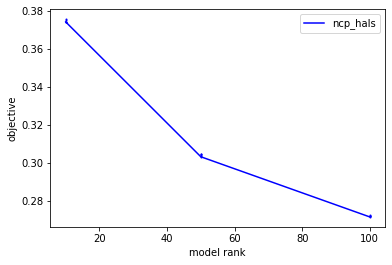

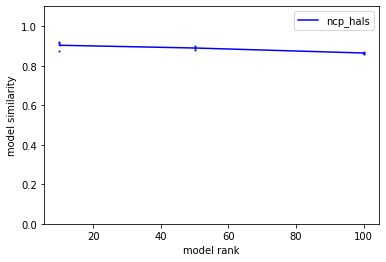

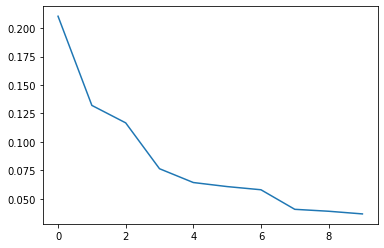

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


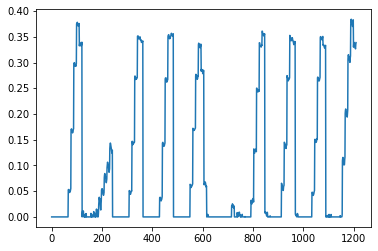

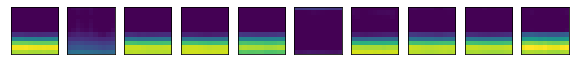

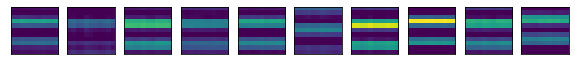

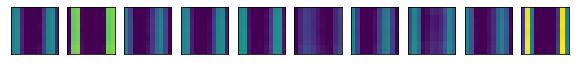

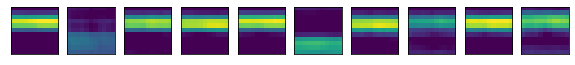

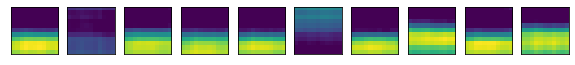

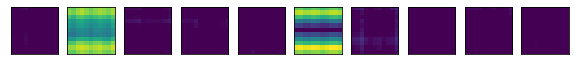

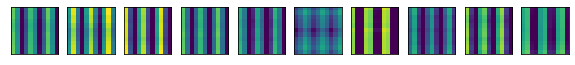

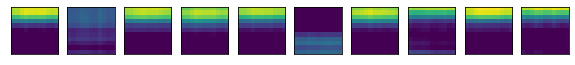

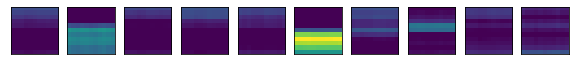

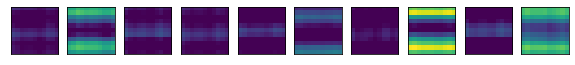

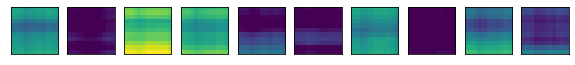

In [ ]:
tensor_factors = get_tensor_factors(N_epoch0_fix)
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 3D epoch 5 fix:

Fitting rank-10 models:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                     

Rank-10 models:  min obj, 0.47;  max obj, 0.47;  time to fit, 154.0s


Rank-50 models:  min obj, 0.40;  max obj, 0.40;  time to fit, 472.8s


Rank-100 models:  min obj, 0.37;  max obj, 0.37;  time to fit, 863.5s


[0.3709219469714491, 0.3710096440217745, 0.3710274764912378, 0.37157207542858517, 0.3717847411188735]
[0.4690409233954877, 0.47058846580221847, 0.4722848363708257, 0.4727862560737921, 0.4727988023777841, 0.399976885838762, 0.4003607825278013, 0.40095838044033627, 0.4010373309520547, 0.40105876624695297, 0.3709219469714491, 0.3710096440217745, 0.3710274764912378, 0.37157207542858517, 0.3717847411188735]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


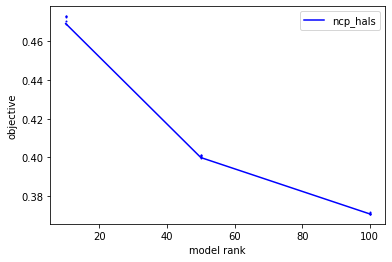

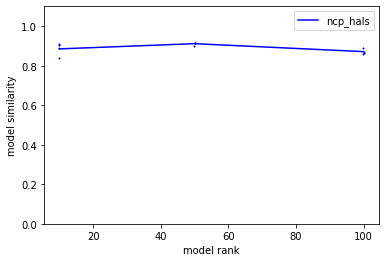

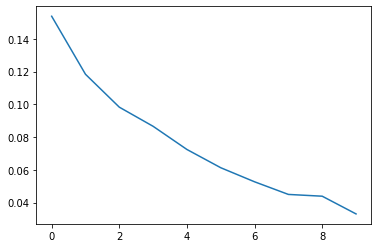

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


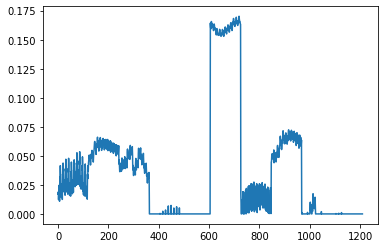

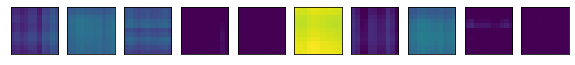

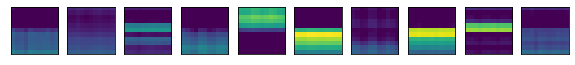

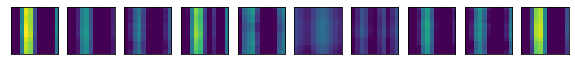

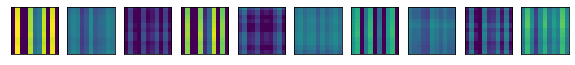

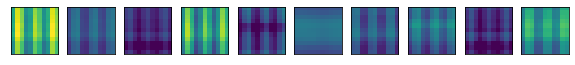

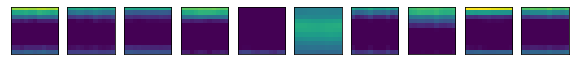

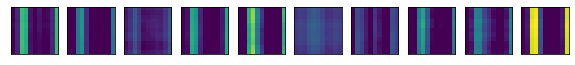

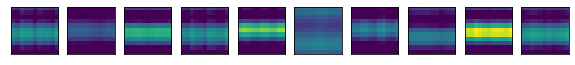

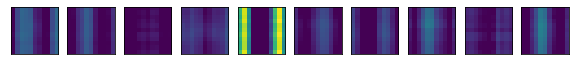

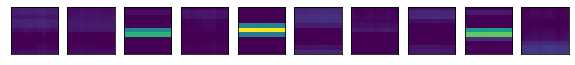

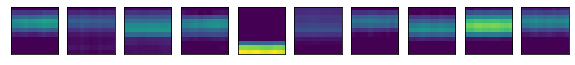

In [ ]:
tensor_factors = get_tensor_factors(N_epoch5_fix)
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 3D epoch 7 fix:

Rank-10 models:  min obj, 0.33;  max obj, 0.34;  time to fit, 47.1s


Rank-50 models:  min obj, 0.28;  max obj, 0.28;  time to fit, 160.3s


Rank-100 models:  min obj, 0.24;  max obj, 0.25;  time to fit, 448.9s


[0.24475721074993004, 0.2448768440456784, 0.2448940780466965, 0.24489450576941238, 0.24534272398321824]
[0.3344287295986132, 0.3344465657087524, 0.3344613075113989, 0.3344969023897351, 0.33636184805018426, 0.2781815622174478, 0.2785295760642969, 0.27861174582629916, 0.2787453089704145, 0.27888195723028986, 0.24475721074993004, 0.2448768440456784, 0.2448940780466965, 0.24489450576941238, 0.24534272398321824]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


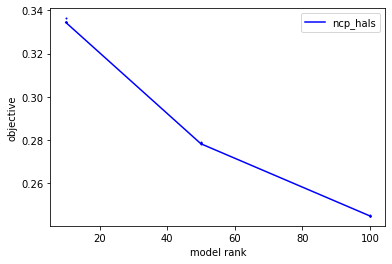

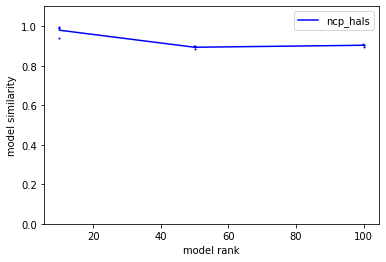

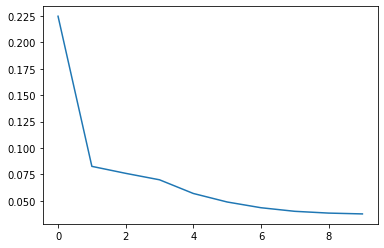

(605, 10)
(605,)
0 121
(605,)
1 121
(605,)
2 121
(605,)
3 121
(605,)
4 121


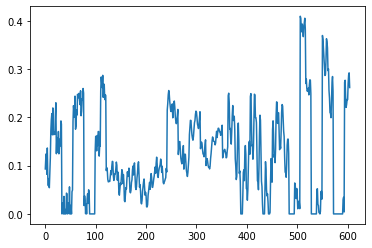

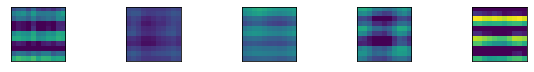

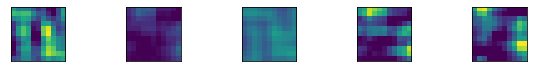

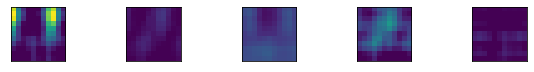

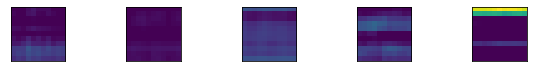

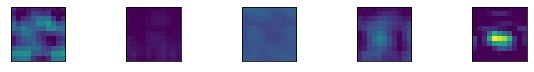

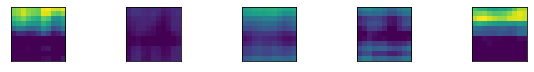

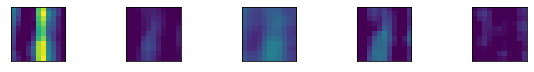

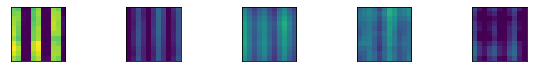

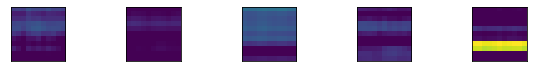

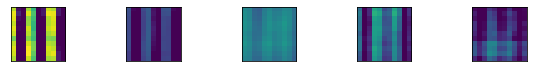

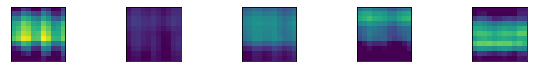

In [ ]:
tensor_factors = get_tensor_factors(N_epoch7_fix_conv1)
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank,neuron_labels)
get_tensor_factors_plot(tensor_factors_best_rank,n_max_feature_maps=5)

## For 3D epoch 10 fix:

Rank-10 models:  min obj, 0.32;  max obj, 0.32;  time to fit, 41.8s


Rank-50 models:  min obj, 0.27;  max obj, 0.27;  time to fit, 194.2s


Rank-100 models:  min obj, 0.23;  max obj, 0.24;  time to fit, 447.8s


[0.23410444540077469, 0.23423197243716712, 0.23479861313920772, 0.2348261882871571, 0.23540732045458745]
[0.3163321934977385, 0.3167923236979573, 0.3168549554474782, 0.31733815278465, 0.31852173849478144, 0.26628110014320194, 0.2663557735543309, 0.26636178815475864, 0.2664512549197606, 0.2670060098349907, 0.23410444540077469, 0.23423197243716712, 0.23479861313920772, 0.2348261882871571, 0.23540732045458745]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


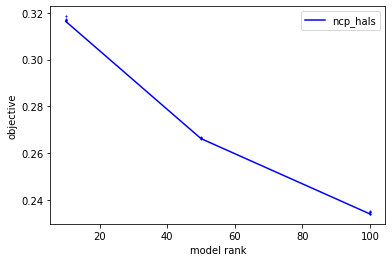

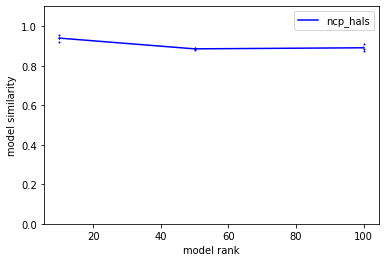

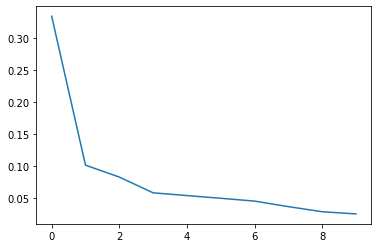

(605, 10)
(605,)
0 121
(605,)
1 121
(605,)
2 121
(605,)
3 121
(605,)
4 121


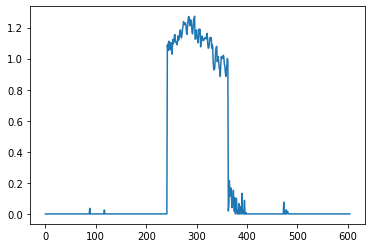

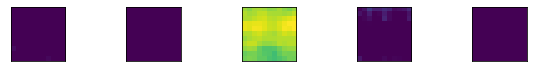

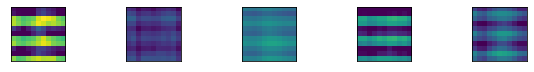

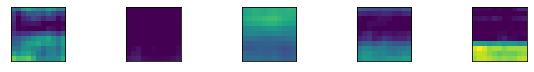

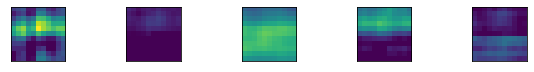

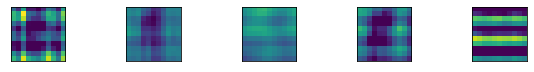

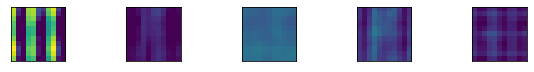

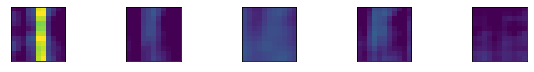

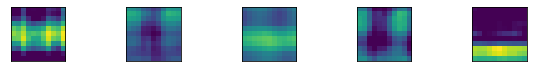

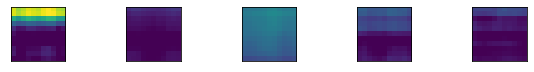

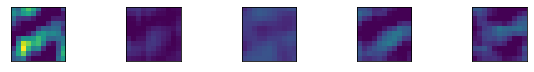

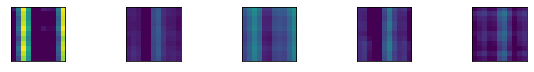

In [ ]:
tensor_factors = get_tensor_factors(N_epoch10_fix_conv1) 
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank, neuron_labels)
get_tensor_factors_plot(tensor_factors_best_rank, n_max_feature_maps=5)

## For 3D epoch 10 max:

Rank-10 models:  min obj, 0.33;  max obj, 0.33;  time to fit, 44.2s


Rank-50 models:  min obj, 0.28;  max obj, 0.28;  time to fit, 208.2s


Rank-100 models:  min obj, 0.25;  max obj, 0.25;  time to fit, 422.2s


[0.25208529800926355, 0.25238997065300794, 0.2526120146850192, 0.2526596964166244, 0.2527381072628313]
[0.3303619367015857, 0.3303831336385556, 0.3307464260002839, 0.3308110908706553, 0.3311284071067648, 0.2835842567122053, 0.28387663569808214, 0.28390768488620316, 0.2839900005248785, 0.2841867334214497, 0.25208529800926355, 0.25238997065300794, 0.2526120146850192, 0.2526596964166244, 0.2527381072628313]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


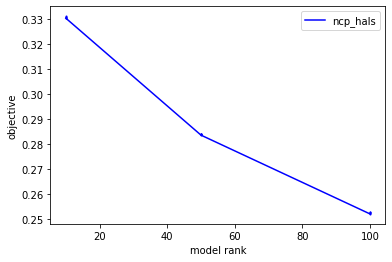

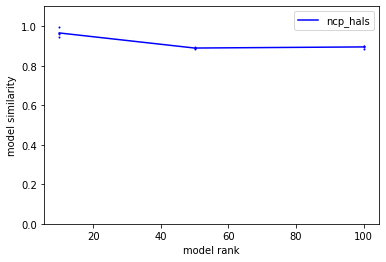

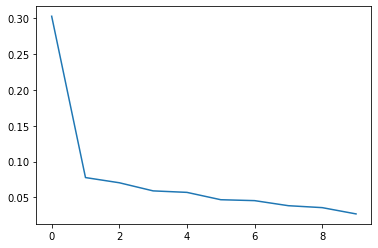

(605, 10)
(605,)
0 121
(605,)
1 121
(605,)
2 121
(605,)
3 121
(605,)
4 121


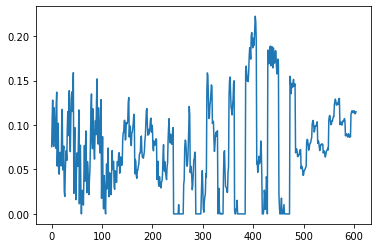

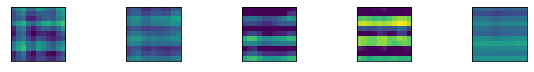

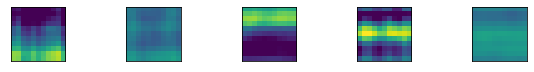

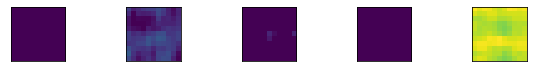

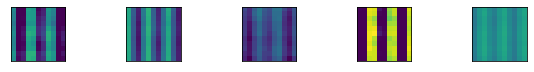

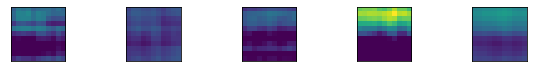

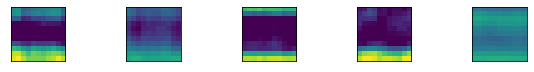

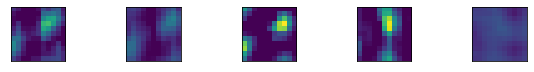

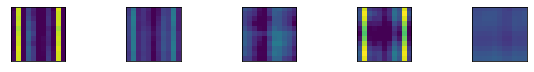

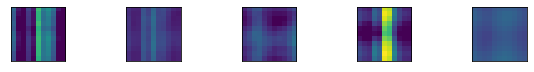

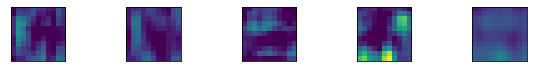

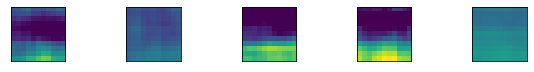

In [ ]:
tensor_factors = get_tensor_factors(N_epoch10_max_conv1) 
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank, neuron_labels)
get_tensor_factors_plot(tensor_factors_best_rank, n_max_feature_maps=5)

## For 3D epoch 12 fix:

Rank-10 models:  min obj, 0.25;  max obj, 0.25;  time to fit, 55.6s


Rank-50 models:  min obj, 0.21;  max obj, 0.21;  time to fit, 198.8s


Rank-100 models:  min obj, 0.18;  max obj, 0.18;  time to fit, 473.2s


[0.18308558278592868, 0.18387429569373973, 0.18394954881882664, 0.18416126215321582, 0.1842299332229646]
[0.24848258154814512, 0.24875233501173483, 0.24899399542716466, 0.24901435545412365, 0.2490959244704482, 0.20826016980080833, 0.20878463513599593, 0.20888562846481978, 0.2089593764385848, 0.20930379793966575, 0.18308558278592868, 0.18387429569373973, 0.18394954881882664, 0.18416126215321582, 0.1842299332229646]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


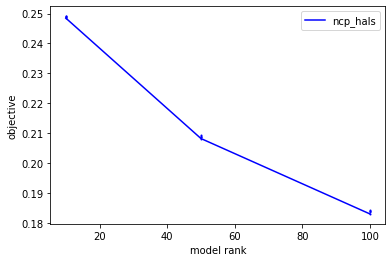

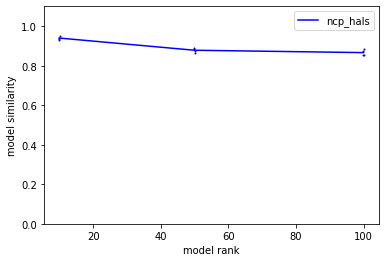

TypeError: ignored

In [ ]:
tensor_factors = get_tensor_factors(N_epoch12_fix_conv1)

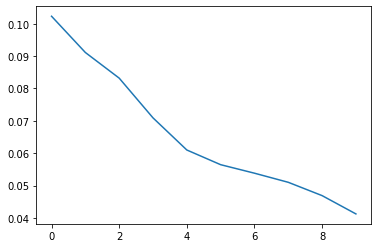

(605, 10)
(605,)
0 121
(605,)
1 121
(605,)
2 121
(605,)
3 121
(605,)
4 121


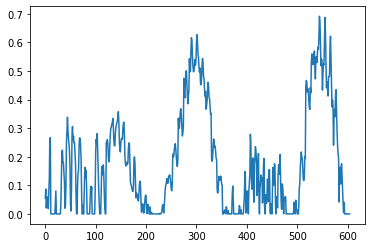

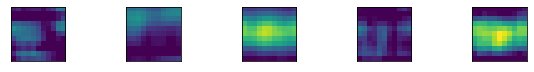

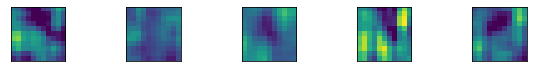

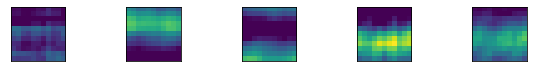

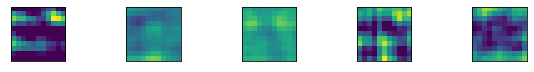

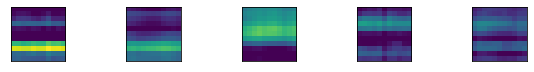

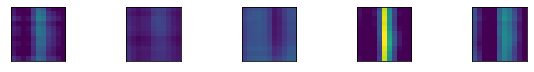

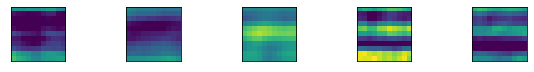

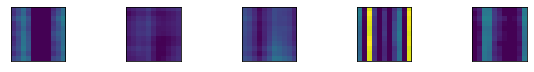

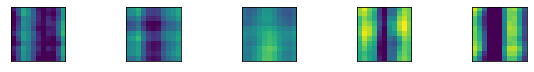

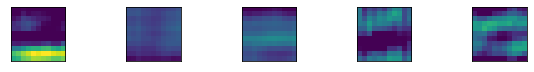

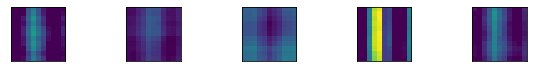

In [ ]:
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank,neuron_labels)
get_tensor_factors_plot(tensor_factors_best_rank,n_max_feature_maps=5)

## For 3D epoch 16 max10:

In [ ]:
N_epoch16_max10_conv1.shape

(605, 10, 1024)

Fitting rank-10 models:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                     

Rank-10 models:  min obj, 0.26;  max obj, 0.26;  time to fit, 63.8s


Rank-50 models:  min obj, 0.21;  max obj, 0.22;  time to fit, 183.9s


Rank-100 models:  min obj, 0.19;  max obj, 0.19;  time to fit, 483.1s


[0.18880409006563584, 0.18891468101687345, 0.18907320588551887, 0.18929625528176044, 0.1894877423464422]
[0.2552747722296886, 0.25535661167669055, 0.2554282856434001, 0.2555376728328066, 0.2557896150481061, 0.21469905677556878, 0.21482901210126024, 0.21501524180259624, 0.2151617399939707, 0.2156202870389922, 0.18880409006563584, 0.18891468101687345, 0.18907320588551887, 0.18929625528176044, 0.1894877423464422]
[10, 10, 10, 10, 10, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100]


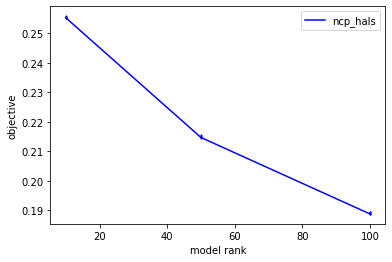

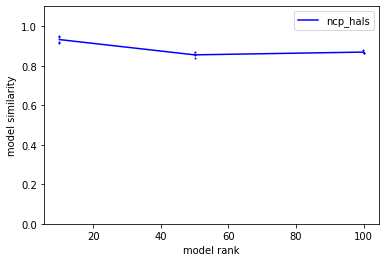

In [ ]:
tensor_factors = get_tensor_factors(N_epoch16_max10_conv1) 

In [ ]:
tensor_factors_best_rank = tensor_factors[1]

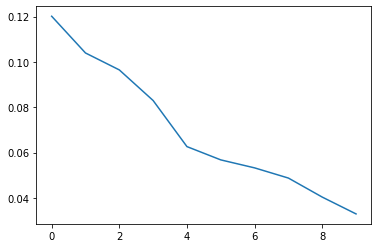

(605, 10)
(605,)
0 121
(605,)
1 121
(605,)
2 121
(605,)
3 121
(605,)
4 121


In [ ]:
get_embeddings(tensor_factors_best_rank, neuron_labels) 

In [ ]:
tensor_factors_best_rank.shape

(605, 50)

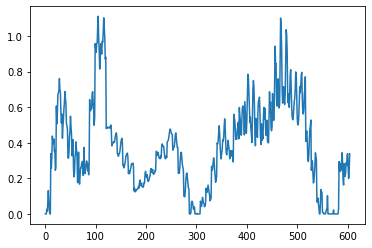

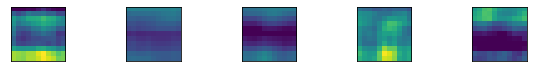

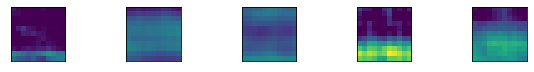

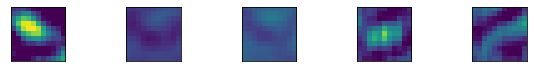

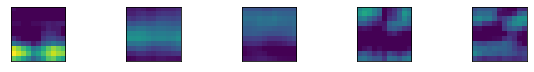

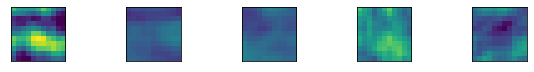

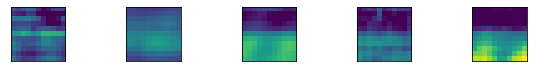

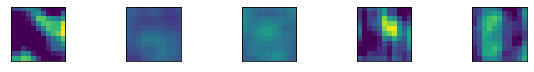

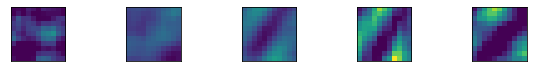

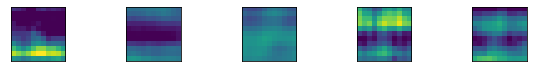

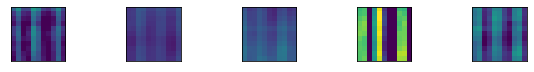

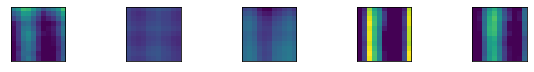

In [ ]:
get_tensor_factors_plot(tensor_factors_best_rank, n_max_feature_maps = 5)

## For 2D epoch 0 fix:

Fitting rank-10 models:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                     

Rank-10 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 8.8s


Rank-20 models:  min obj, 0.00;  max obj, 0.01;  time to fit, 5.6s


Rank-30 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 23.7s


Rank-40 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 27.5s


[0.0022599020686108907, 0.0023279448345733824, 0.0024125263620101115, 0.0024206413113651393, 0.0025471694490569706]
[0.006927536155515081, 0.007054433075553899, 0.009380178541124273, 0.009517243829368232, 0.012886209066104402, 0.00470375183114973, 0.004717823611153517, 0.005046153616950069, 0.0051033848415039575, 0.005169771080226815, 0.0032459233608271134, 0.0033547794760167694, 0.003406369249055078, 0.0034153825574450344, 0.0034807689731603925, 0.0022599020686108907, 0.0023279448345733824, 0.0024125263620101115, 0.0024206413113651393, 0.0025471694490569706]
[10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40]


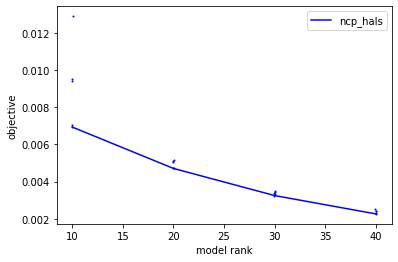

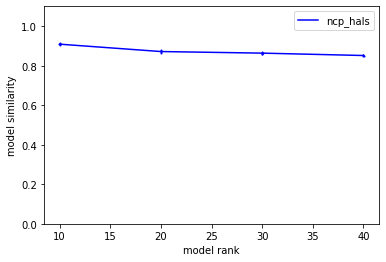

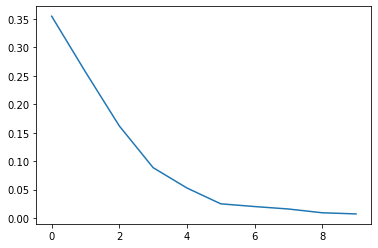

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


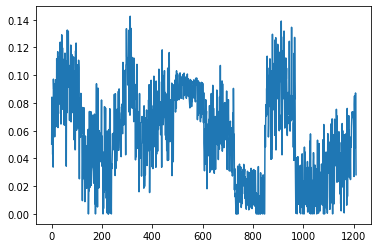

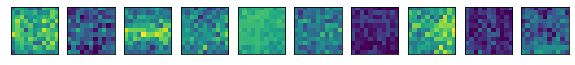

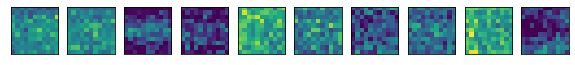

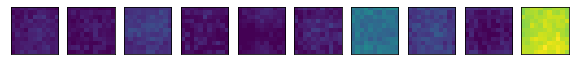

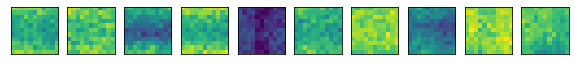

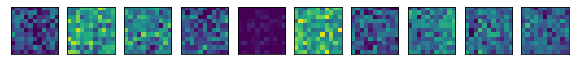

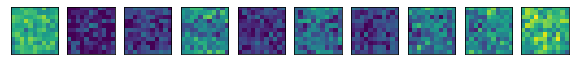

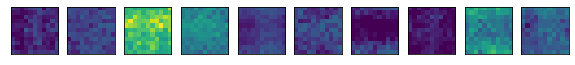

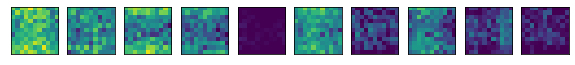

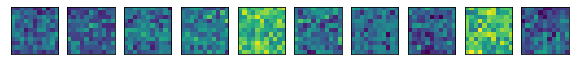

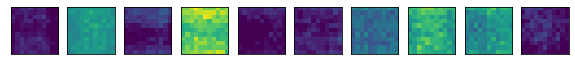

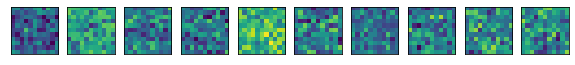

In [ ]:
tensor_factors = get_tensor_factors(N_epoch0_fix_2D, dim = 2, ranks = [10,20,30,40])
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

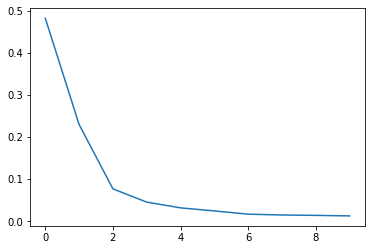

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


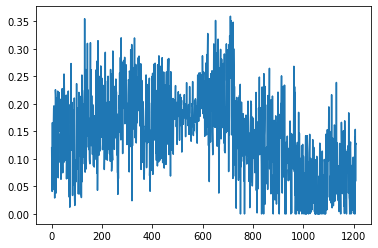

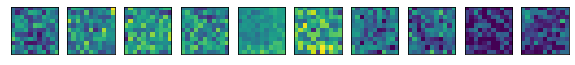

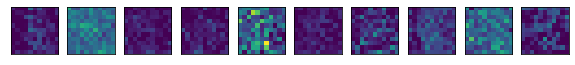

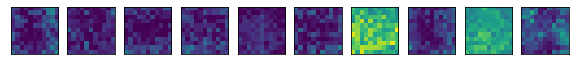

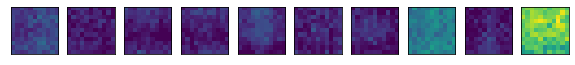

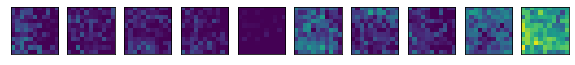

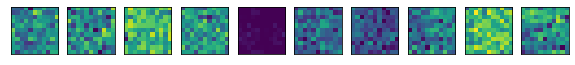

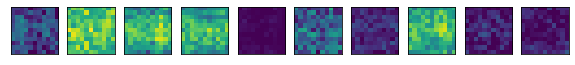

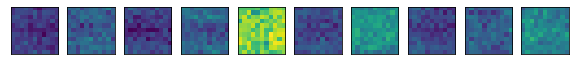

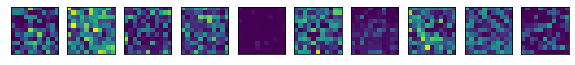

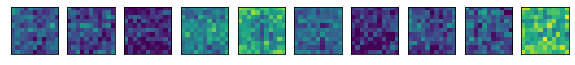

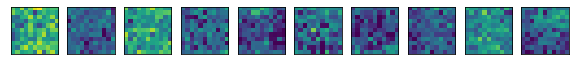

In [ ]:
tensor_factors_best_rank = tensor_factors[2]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 2D epoch 5 fix:

Rank-10 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 3.7s


Rank-20 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 8.5s


Rank-30 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 21.4s


Rank-40 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 18.5s


[0.0028198776434959797, 0.0028834337516855596, 0.002958792332543897, 0.002959250868114056, 0.0029669584048426802]
[0.012969121762593572, 0.012988230043780363, 0.013088594093308141, 0.013200534010932137, 0.013249778297081844, 0.006873637185941919, 0.00688097624811407, 0.006895400611329205, 0.007094156040227035, 0.007144222093768436, 0.004378801612430631, 0.004432793615055211, 0.004469536779324299, 0.0045771842643206224, 0.004586002442537676, 0.0028198776434959797, 0.0028834337516855596, 0.002958792332543897, 0.002959250868114056, 0.0029669584048426802]
[10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40]


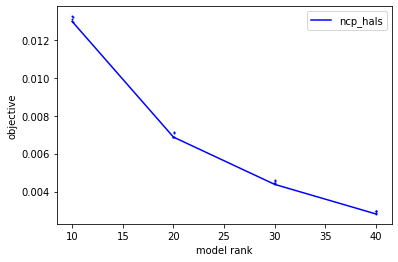

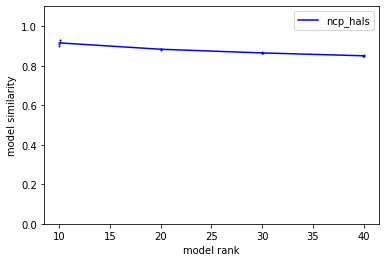

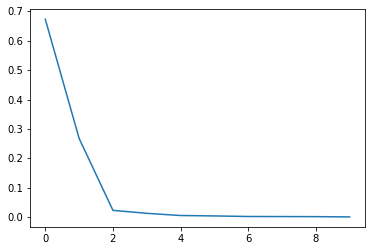

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


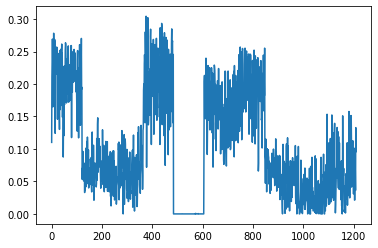

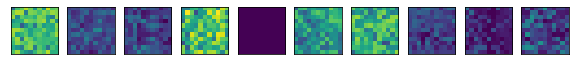

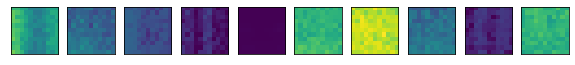

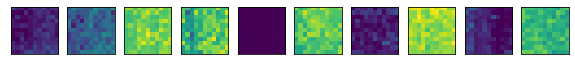

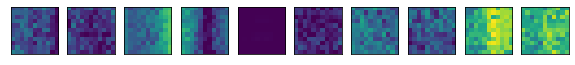

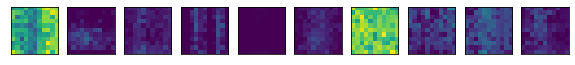

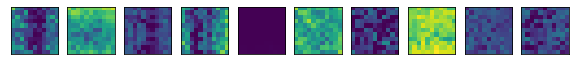

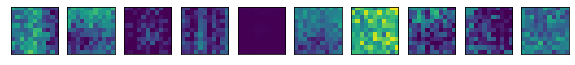

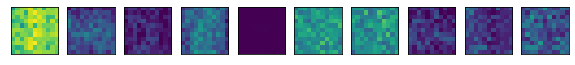

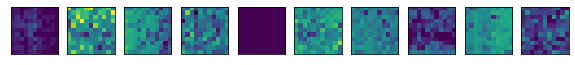

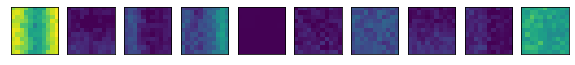

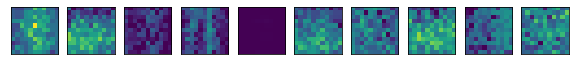

In [ ]:
tensor_factors = get_tensor_factors(N_epoch5_fix_2D, dim = 2, ranks = [10,20,30,40])
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

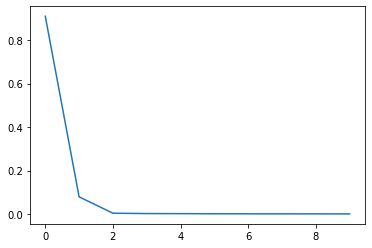

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


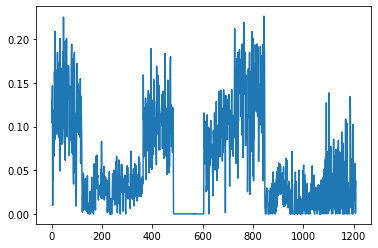

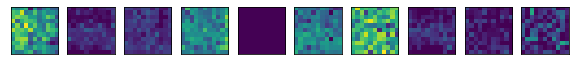

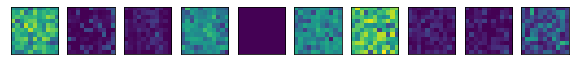

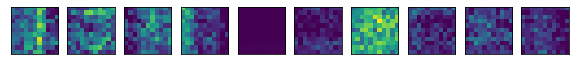

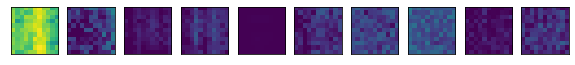

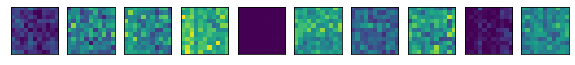

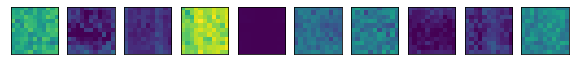

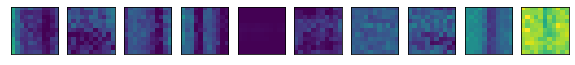

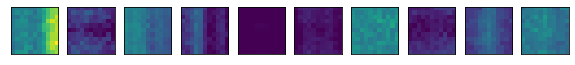

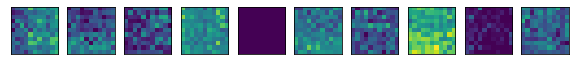

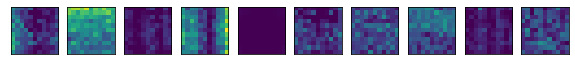

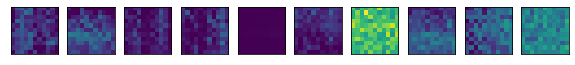

In [ ]:
tensor_factors_best_rank = tensor_factors[2]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 2D epoch 7 fix: 

Rank-10 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 4.7s


Rank-20 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 8.9s


Rank-30 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 15.1s


Rank-40 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 19.8s


[0.00282217862094062, 0.002911224721645645, 0.0029141078271376995, 0.002980133389521817, 0.003044683315053499]
[0.01213117818260271, 0.012148999435865572, 0.01215207657324361, 0.012211089684217536, 0.012397273065691891, 0.006767779053733873, 0.006860469426140331, 0.006917010500495076, 0.007029526079388374, 0.007288658737110613, 0.00419985325896141, 0.004555392952633541, 0.004586908243120559, 0.004711252172074262, 0.004805263359402073, 0.00282217862094062, 0.002911224721645645, 0.0029141078271376995, 0.002980133389521817, 0.003044683315053499]
[10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40]


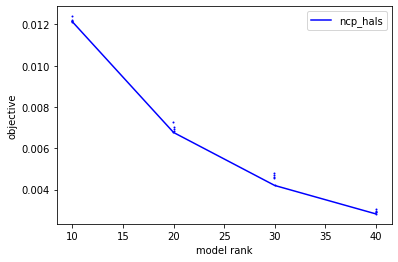

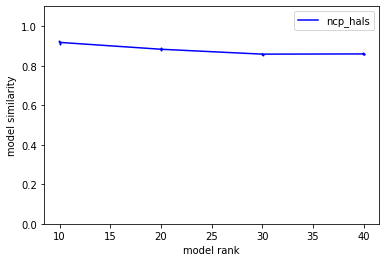

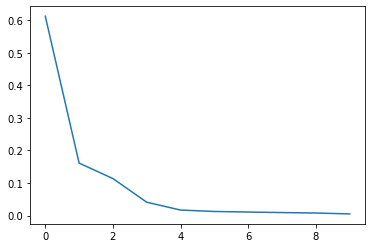

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


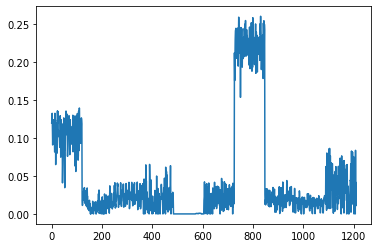

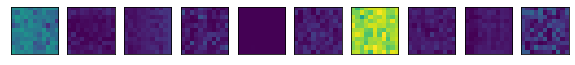

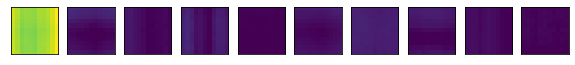

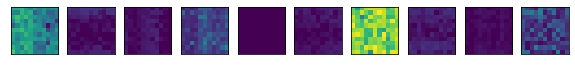

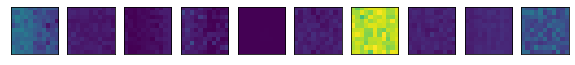

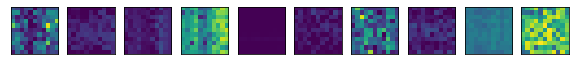

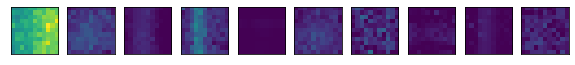

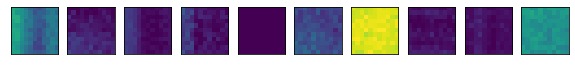

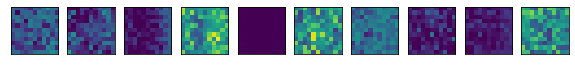

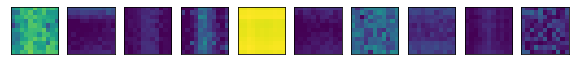

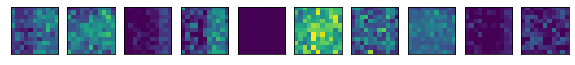

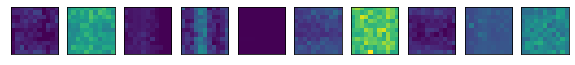

In [ ]:
tensor_factors = get_tensor_factors(N_epoch7_fix_2D, dim = 2, ranks = [10,20,30,40])
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

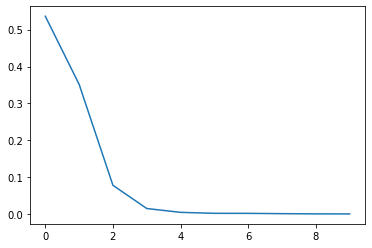

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


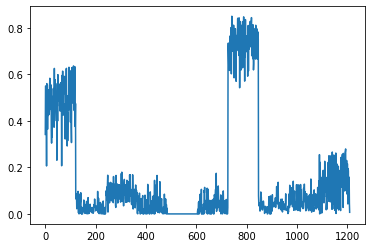

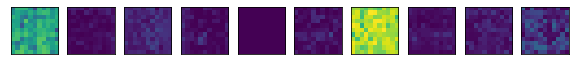

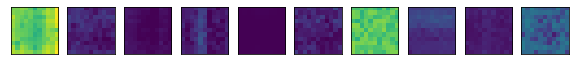

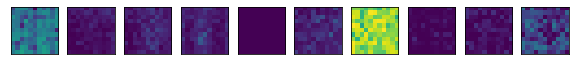

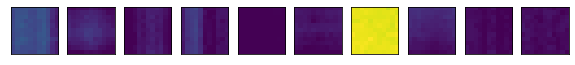

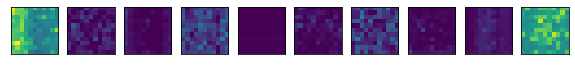

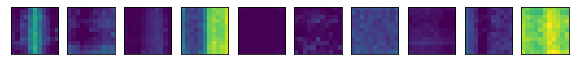

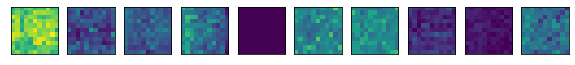

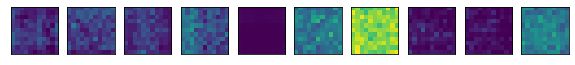

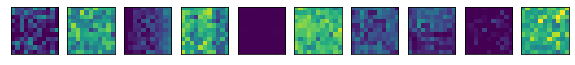

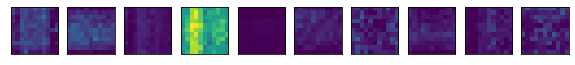

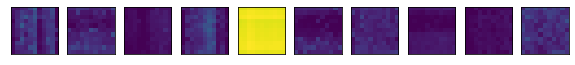

In [ ]:
tensor_factors_best_rank = tensor_factors[2]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 2D epoch 12 fix:

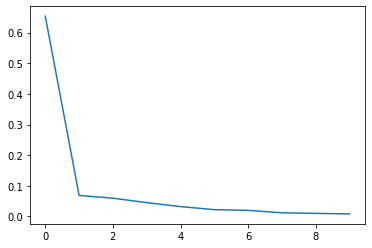

In [ ]:
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(tensor_factors[2])
neuron_output_highest_with_shifts_projected.shape
vectors, lambdas = pca.components_, pca.explained_variance_
plt.plot(pca.explained_variance_ratio_)
plt.show()

Rank-10 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 3.7s


Rank-20 models:  min obj, 0.00;  max obj, 0.01;  time to fit, 6.0s


Rank-30 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 11.3s


Rank-40 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 18.3s


[0.002308770398457675, 0.0024398226254454527, 0.002455606941248889, 0.0024645480004099247, 0.002606683792822922]
[0.007024174279641547, 0.007057080019645305, 0.0070614758390755246, 0.007094608754320146, 0.0071174498172895265, 0.00480024525368417, 0.004970250788065073, 0.0051818303847173805, 0.005209075332610503, 0.0055863353583488744, 0.0034710067354495103, 0.0034731492154145924, 0.003506873125149603, 0.003523806962586158, 0.0039774405198410604, 0.002308770398457675, 0.0024398226254454527, 0.002455606941248889, 0.0024645480004099247, 0.002606683792822922]
[10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40]


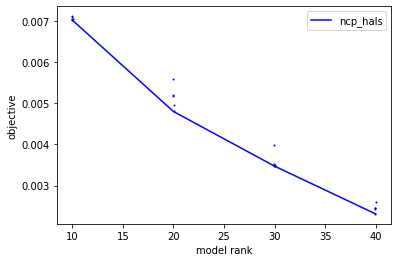

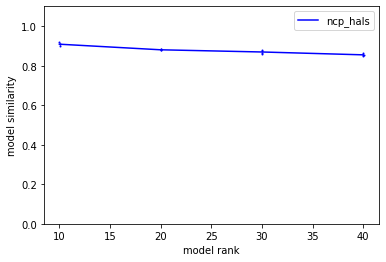

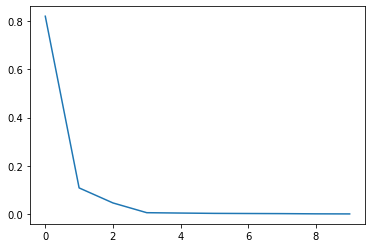

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


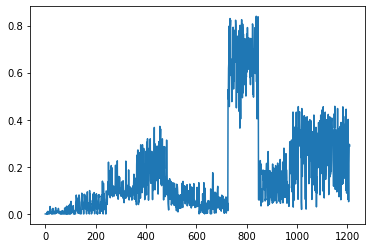

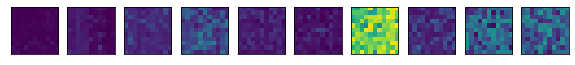

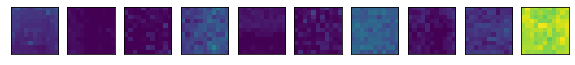

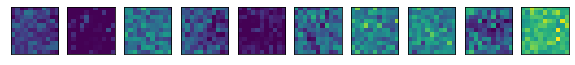

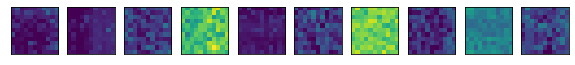

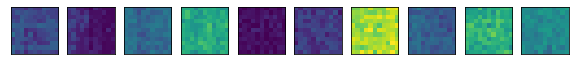

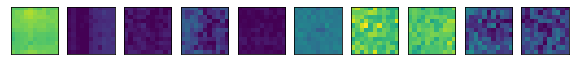

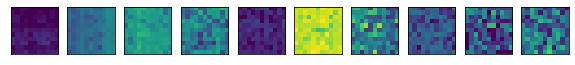

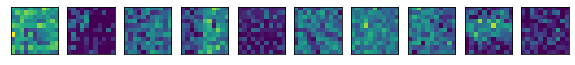

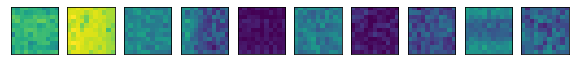

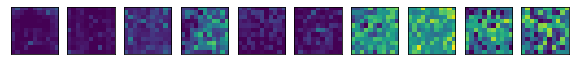

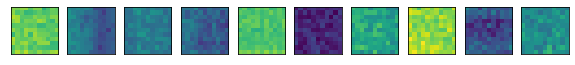

In [ ]:
tensor_factors = get_tensor_factors(N_epoch12_fix_2D, dim = 2, ranks = [10,20,30,40])
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

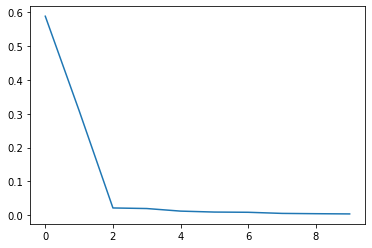

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


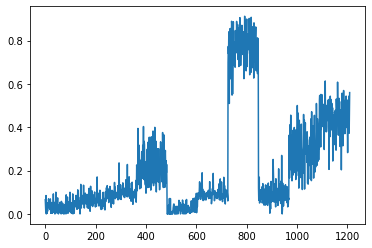

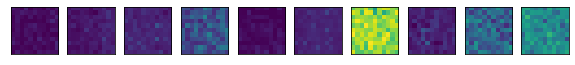

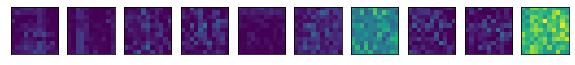

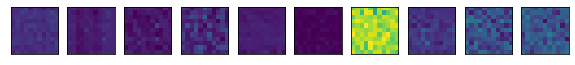

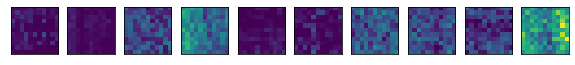

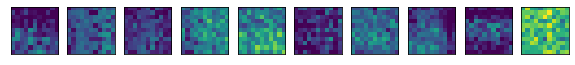

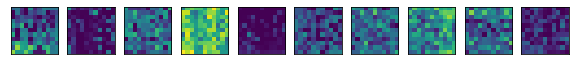

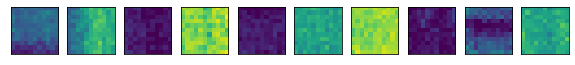

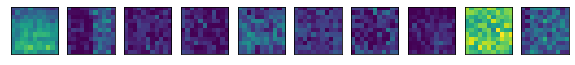

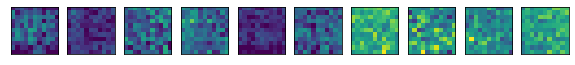

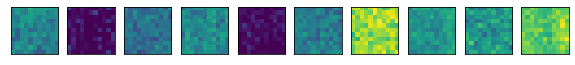

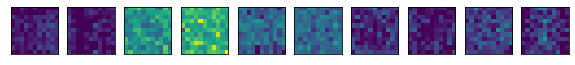

In [ ]:
tensor_factors_best_rank = tensor_factors[2]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

## For 2D epoch 16 max 10:


Rank-10 models:  min obj, 0.01;  max obj, 0.01;  time to fit, 6.9s


Rank-20 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 10.4s


Rank-30 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 16.8s


Rank-40 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 17.1s


[0.002365554566223096, 0.0025214694394109435, 0.002621918518757926, 0.0026272981679309974, 0.002702483691486782]
[0.006891250045320931, 0.00690695351250267, 0.006918445377979029, 0.006932329573263565, 0.00696727960667959, 0.004761396143271907, 0.004792999735094773, 0.0048648124522500825, 0.004973187659907736, 0.004992840332501608, 0.003236672518849385, 0.003320401153478294, 0.0033756777657864613, 0.003411801763553447, 0.0035334675539479285, 0.002365554566223096, 0.0025214694394109435, 0.002621918518757926, 0.0026272981679309974, 0.002702483691486782]
[10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40]


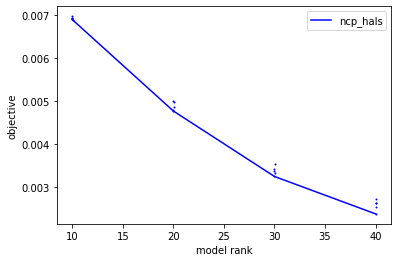

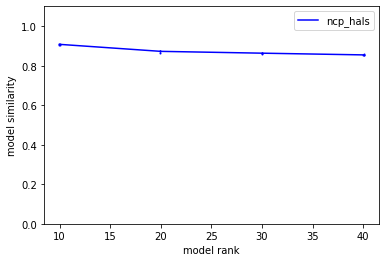

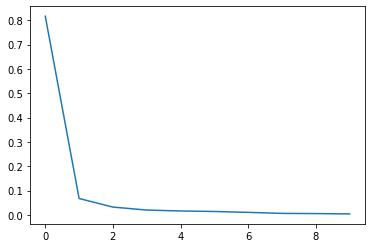

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


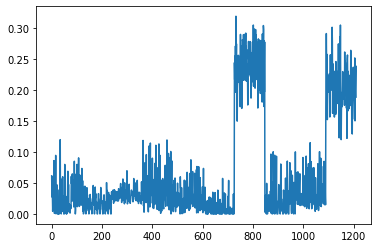

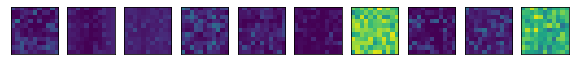

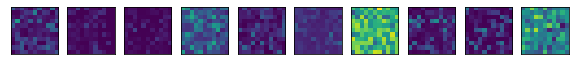

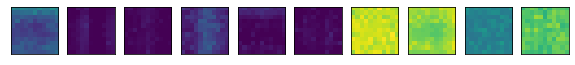

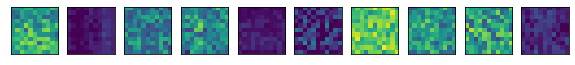

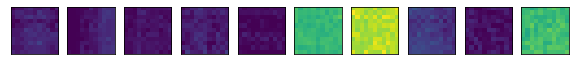

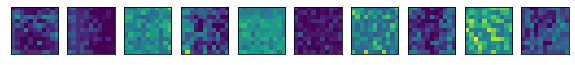

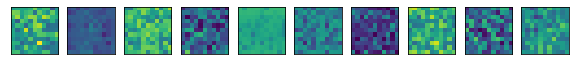

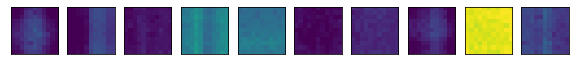

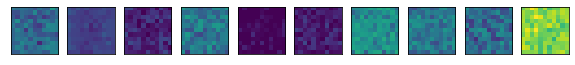

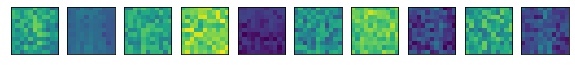

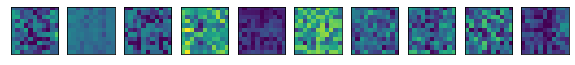

In [ ]:
tensor_factors = get_tensor_factors(N_epoch16_max10_2D, dim = 2, ranks = [10,20,30,40])
tensor_factors_best_rank = tensor_factors[1]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

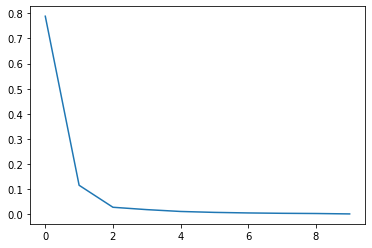

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


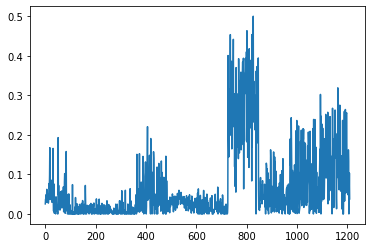

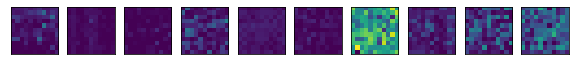

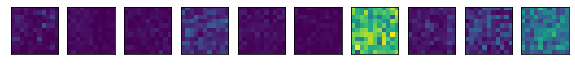

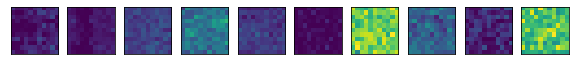

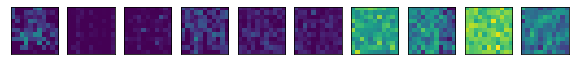

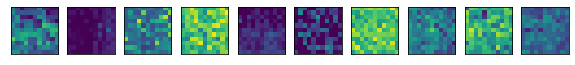

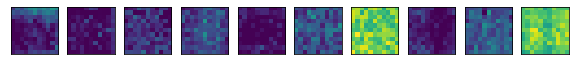

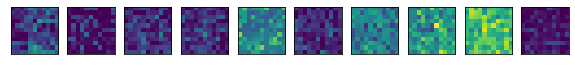

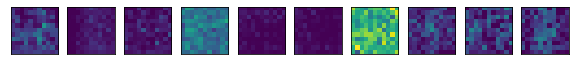

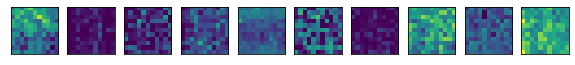

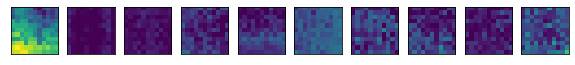

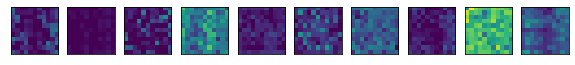

In [ ]:
tensor_factors_best_rank = tensor_factors[2]
get_embeddings(tensor_factors_best_rank)
get_tensor_factors_plot(tensor_factors_best_rank)

In [ ]:
!pip install tensorly

     |████████████████████████████████| 198 kB 5.0 MB/s 
     |████████████████████████████████| 154 kB 34.4 MB/s 


In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac, non_negative_parafac_hals
from tensorly.decomposition._nn_cp import initialize_nn_cp
from tensorly.cp_tensor import CPTensor
import time
from copy import deepcopy

In [ ]:
tic = time.time()
weights_init, factors_init = initialize_nn_cp(N_epoch16_max10_2D, init='random', rank=10)
cp_init = CPTensor((weights_init, factors_init))
tensor_hals, errors_hals = non_negative_parafac_hals(N_epoch16_max10_2D, rank=10, init=deepcopy(cp_init), return_errors=True)
cp_reconstruction_hals = tl.cp_to_tensor(tensor_hals)
time_hals = time.time()-tic

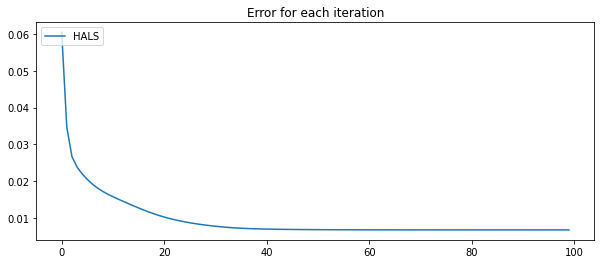

In [ ]:
import matplotlib.pyplot as plt
def each_iteration(a, title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.title(str(title))
    plt.legend(['HALS'], loc='upper left')

each_iteration(errors_hals, 'Error for each iteration')

In [ ]:
tic = time.time()
weights_init, factors_init = initialize_nn_cp(N_epoch16_max10, init='random', rank=10)
cp_init = CPTensor((weights_init, factors_init))
tensor_hals_3D, errors_hals_3D = non_negative_parafac_hals(N_epoch16_max10, rank=10, init=deepcopy(cp_init), return_errors=True)
cp_reconstruction_hals_3D = tl.cp_to_tensor(tensor_hals_3D)
time_hals = time.time()-tic

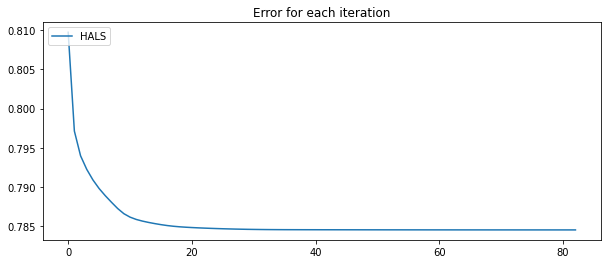

In [ ]:
import matplotlib.pyplot as plt
def each_iteration(a, title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.title(str(title))
    plt.legend(['HALS'], loc='upper left')

each_iteration(errors_hals_3D, 'Error for each iteration')

In [ ]:
N = N_epoch16_max10
N_filtered = np.empty(N.shape)
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    filtered = gaussian_filter(N[i,j,:].reshape((32,32)), sigma=1).reshape((1024,))
    N_filtered[i,j,:] = filtered[:]
tic = time.time()
weights_init, factors_init = initialize_nn_cp(N_filtered, init='random', rank=10)
cp_init = CPTensor((weights_init, factors_init))
tensor_hals_3D, errors_hals_3D = non_negative_parafac_hals(N_filtered, rank=10, init=deepcopy(cp_init), return_errors=True)
cp_reconstruction_hals_3D = tl.cp_to_tensor(tensor_hals_3D)
time_hals = time.time()-tic

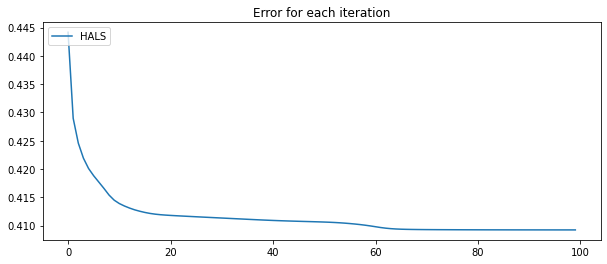

In [ ]:
import matplotlib.pyplot as plt
def each_iteration(a, title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.title(str(title))
    plt.legend(['HALS'], loc='upper left')

each_iteration(errors_hals_3D, 'Error for each iteration')

# Get accuracy:

In [ ]:
!pip install tqdm
import tqdm

In [ ]:
# define function to calculate current accuracy with a given dataloader
def accuracy(net, dataloader, device='cpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(trainloader):
    data = data.to(device).float()
    target = target.to(device).long()
    data = data.type(torch.cuda.FloatTensor)
    target = target.type(torch.cuda.FloatTensor)

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='cpu', title=""):
  net.eval()
  train_count, train_acc = accuracy(net, train_data, device=device)
  test_count, test_acc = accuracy(net, test_data, device=device)
  print(f'Accuracy on the {train_count} training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} testing samples {title}: {test_acc:0.2f}')

In [ ]:
evaluate(AlexNet_Model_epoch25)

100%|██████████| 12500/12500 [01:02<00:00, 198.79it/s]

Accuracy on the 50000 training samples : 99.10
Accuracy on the 50000 testing samples : 99.10


In [ ]:
evaluate(AlexNet_Model_epoch1)

100%|██████████| 12500/12500 [01:03<00:00, 196.71it/s]

Accuracy on the 50000 training samples : 55.35
Accuracy on the 50000 testing samples : 55.35


In [ ]:
evaluate(AlexNet_Model_epoch2)

100%|██████████| 12500/12500 [01:04<00:00, 194.33it/s]

Accuracy on the 50000 training samples : 66.60
Accuracy on the 50000 testing samples : 66.60


In [ ]:
evaluate(AlexNet_Model_epoch3)

100%|██████████| 12500/12500 [01:04<00:00, 195.03it/s]

Accuracy on the 50000 training samples : 77.75
Accuracy on the 50000 testing samples : 77.75


In [ ]:
evaluate(AlexNet_Model_epoch4)

100%|██████████| 12500/12500 [01:44<00:00, 119.93it/s]

Accuracy on the 50000 training samples : 82.29
Accuracy on the 50000 testing samples : 82.29


In [ ]:
evaluate(AlexNet_Model_epoch5)

100%|██████████| 12500/12500 [01:07<00:00, 184.94it/s]

Accuracy on the 50000 training samples : 80.61
Accuracy on the 50000 testing samples : 80.61


In [ ]:
evaluate(AlexNet_Model_epoch6)

100%|██████████| 12500/12500 [01:05<00:00, 190.20it/s]

Accuracy on the 50000 training samples : 10.00
Accuracy on the 50000 testing samples : 10.00


In [ ]:
evaluate(AlexNet_Model_epoch8)

100%|██████████| 12500/12500 [01:04<00:00, 194.06it/s]

Accuracy on the 50000 training samples : 85.84
Accuracy on the 50000 testing samples : 85.84


In [ ]:
evaluate(AlexNet_Model_epoch10)

100%|██████████| 12500/12500 [01:05<00:00, 190.58it/s]

Accuracy on the 50000 training samples : 89.40
Accuracy on the 50000 testing samples : 89.40


# Visualizing filters:

In [ ]:
def show_weights(layer, i=0):
    filters = layer[0].weight.cpu().data # [0] is to get the conv_2d layer

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    print(filters.shape)

    fig, axs = plt.subplots(5, 5, figsize =(20, 10))
    for i , ax in enumerate(axs.flatten()):
        image = filters[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout
    # img = torchvision.utils.make_grid(filters)
    # npimg = img.numpy()
    # print(npimg.shape)
    # print(np.transpose(npimg, (1, 2, 0)).shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

torch.Size([32, 3, 11, 11])


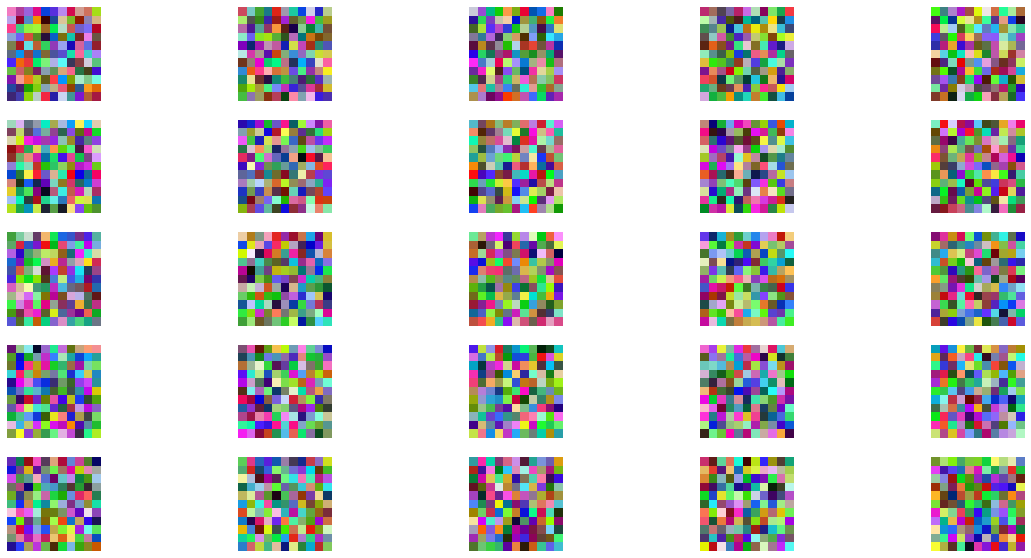

In [ ]:
show_weights(AlexNet_Model_epoch0.conv_layer1)

torch.Size([32, 3, 11, 11])


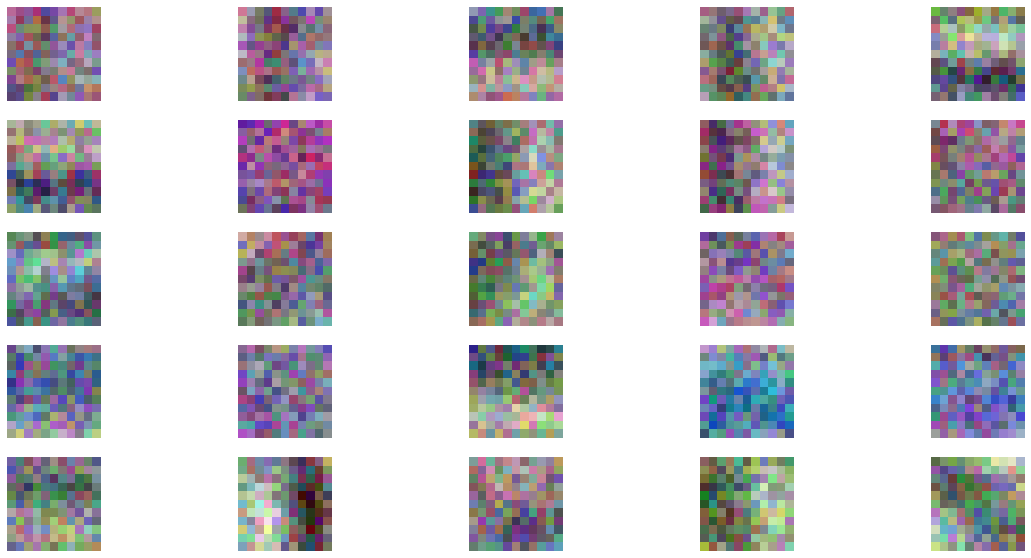

In [ ]:
show_weights(AlexNet_Model_epoch1.conv_layer1)

torch.Size([32, 3, 11, 11])


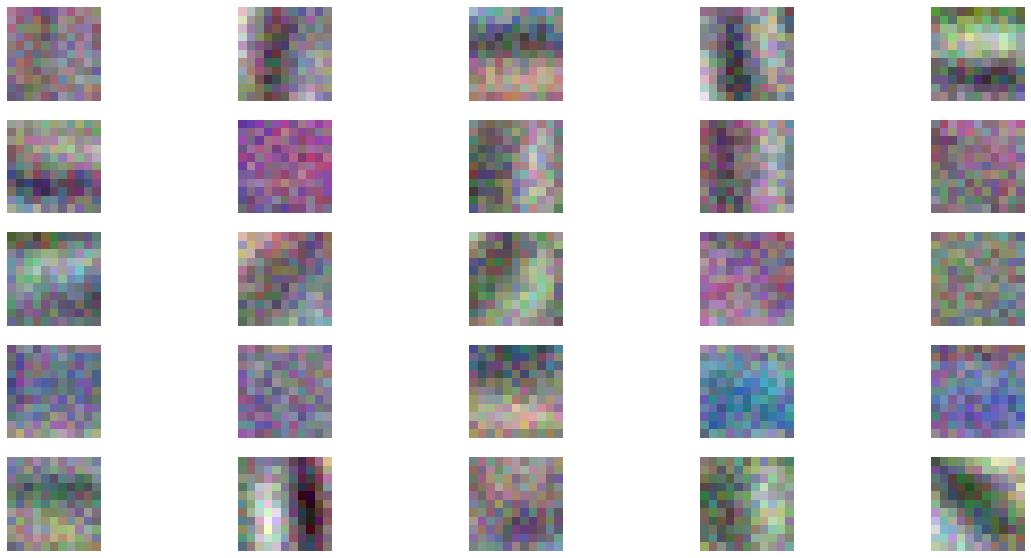

In [ ]:
show_weights(AlexNet_Model_epoch2.conv_layer1)

torch.Size([32, 3, 11, 11])


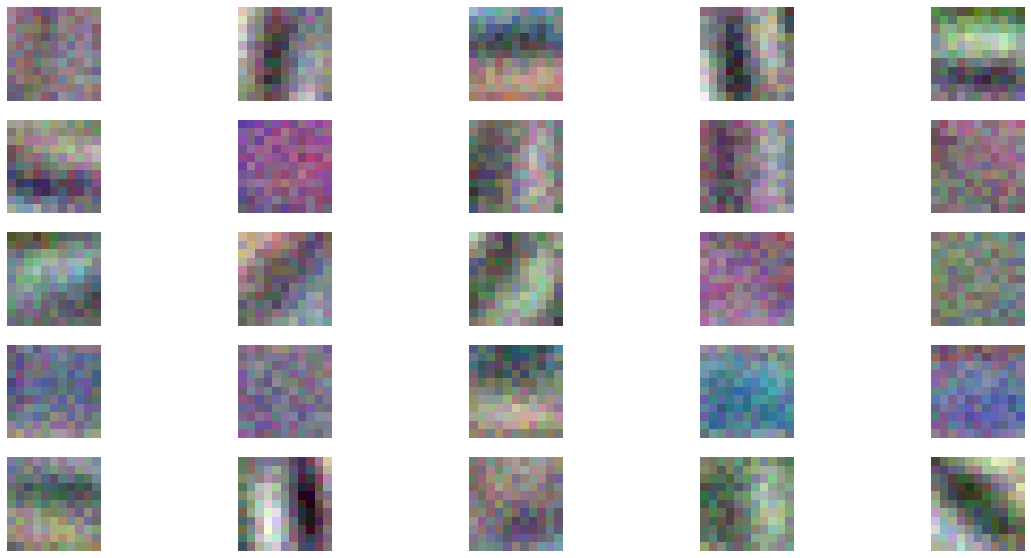

In [ ]:
show_weights(AlexNet_Model_epoch3.conv_layer1)

torch.Size([32, 3, 11, 11])


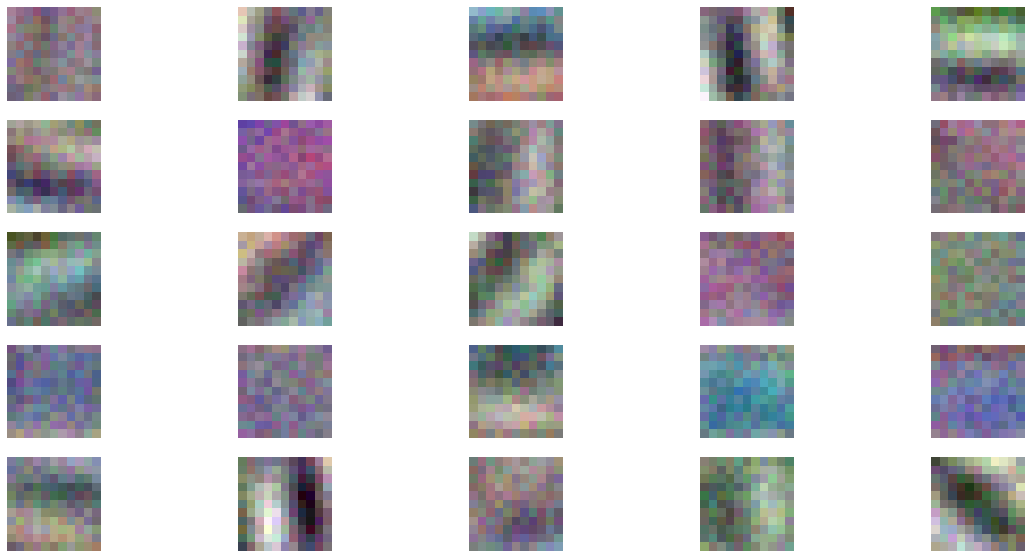

In [ ]:
show_weights(AlexNet_Model_epoch4.conv_layer1)

torch.Size([32, 3, 11, 11])


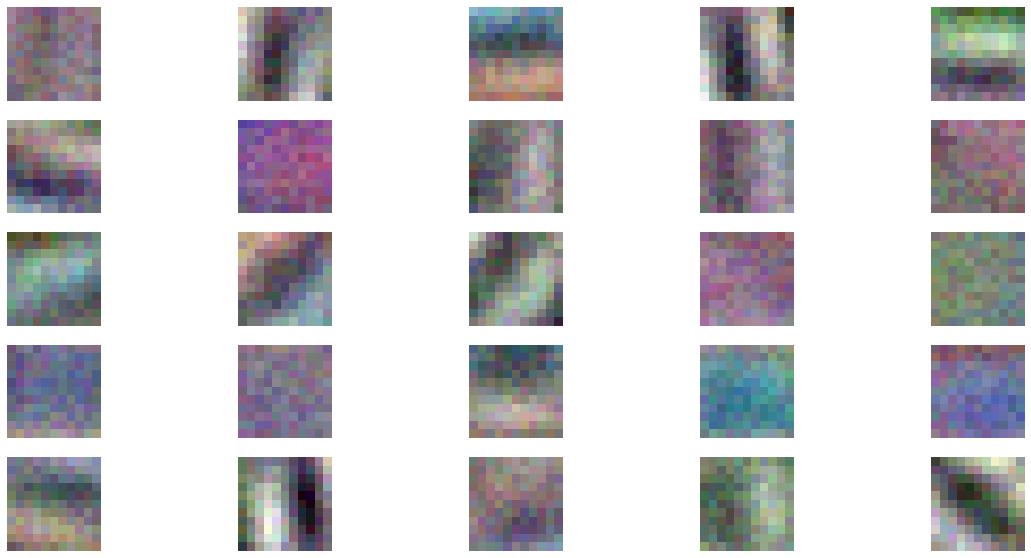

In [ ]:
show_weights(AlexNet_Model_epoch5.conv_layer1)

torch.Size([32, 3, 11, 11])


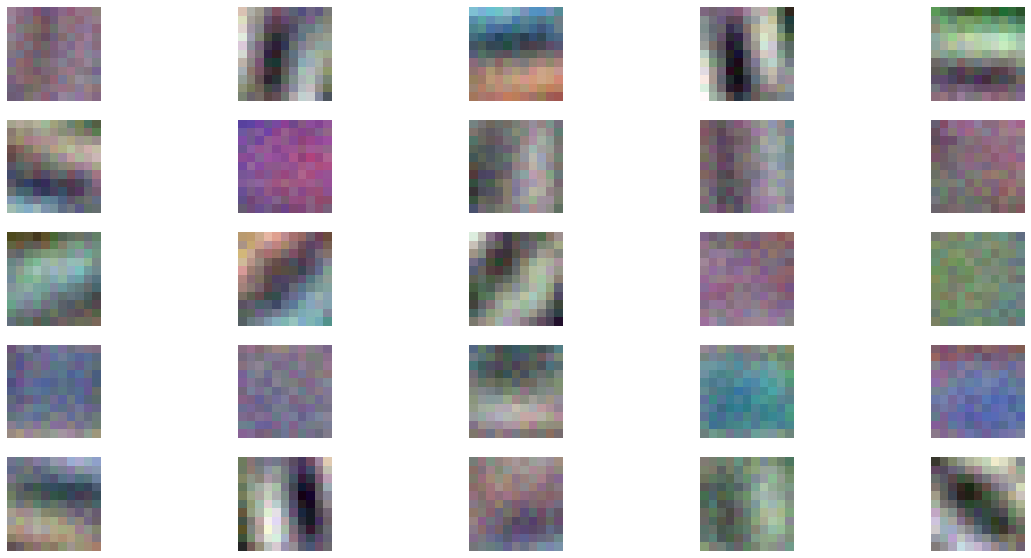

In [ ]:
show_weights(AlexNet_Model_epoch10.conv_layer1)

# Visualizing outputs given an image: 

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


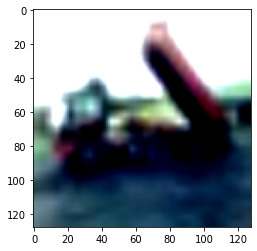

In [ ]:
imshow(images[2])

In [ ]:
images = images.type(torch.cuda.FloatTensor)
im = images[0].unsqueeze(0)

In [ ]:
im.shape

torch.Size([1, 3, 128, 128])

In [ ]:
!pip install torch_intermediate_layer_getter

  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3726 sha256=413a0eb5dda8e008b9554acb528ffbf0ed4dad7c8b933b54912a197e77c0f9b8
  Stored in directory: /root/.cache/pip/wheels/59/53/37/8b81c4711686fbae03a35d8d1dac5edd9e4af9221fa8e17f6f
Successfully built torch-intermediate-layer-getter


In [ ]:
## DEBUG NOTE: https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/12
## The forward hook registered in model.fc returns the “pre-relu” activation, since negative values are shown.

import torchvision
from torchvision.models._utils import IntermediateLayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
model_with_multuple_layer = IntermediateLayerGetter(AlexNet_Model_epoch7, return_layers=return_layers)
intermediate_output = model_with_multuple_layer(im)
intermediate_output

OrderedDict([('conv_layer1',
              tensor([[[[-0.0120,  0.0889,  0.0177,  ..., -0.2436, -0.2436, -0.6147],
                        [ 0.1577, -0.0120, -0.2683,  ..., -0.2708, -0.3270, -0.6649],
                        [ 0.1327, -0.2111, -0.1840,  ...,  0.0845, -0.5043, -0.3859],
                        ...,
                        [-0.0561, -0.0561,  0.1311,  ..., -0.3304,  0.8404,  0.6801],
                        [-0.3968, -0.2732, -0.0397,  ..., -0.3304,  0.8404,  0.0070],
                        [-0.4007, -0.5579, -0.3417,  ..., -0.0590,  1.6005, -0.0760]],
              
                       [[ 1.6084, -1.0132, -1.0132,  ..., -1.0132, -1.0132, -1.0132],
                        [ 1.7945, -1.0132, -1.0132,  ..., -1.0132, -1.0132, -1.0132],
                        [ 1.6400, -1.0132, -1.0132,  ..., -1.0132, -1.0132, -1.0132],
                        ...,
                        [-0.5556, -1.0132, -0.8300,  ..., -0.6844,  0.6897,  0.6897],
                        [ 0.1608, -0.

In [ ]:
# from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
# return_layers = {
#     # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
#       'conv_layer1': 'conv_layer1',
#       'conv_layer3': 'conv_layer3',
#       'conv_layer5': 'conv_layer5',
#   }
# net = AlexNet_Model_epoch7
# LayerGetter_ = LayerGetter(net, return_layers=return_layers)
# intermediate_output = LayerGetter_(im)
# print(intermediate_output['conv_layer1'].shape)
# intermediate_output['conv_layer1'].min()

TypeError: ignored

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

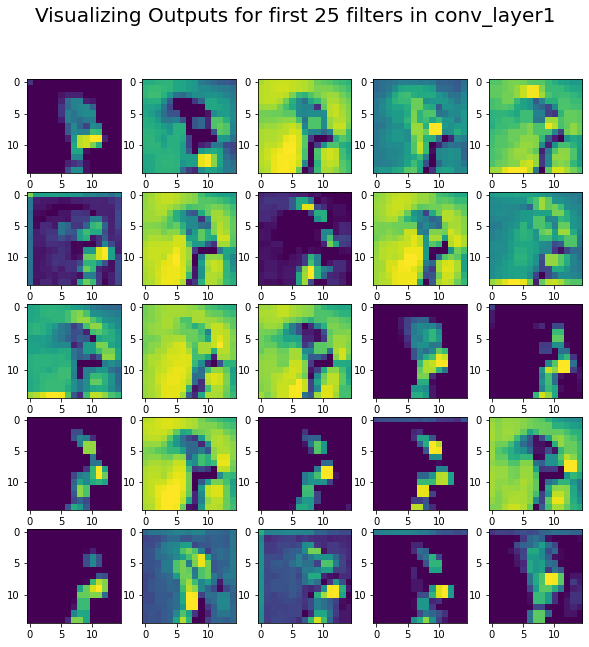

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][1,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

# Visualizing embeddings (3D tensor):

In [19]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[1]
    im_size_horizontal = im.shape[2]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=1)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=2)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

Note: 
output size = [(W−K+2P)/S]+1 = (128-11)/4+1 = ~30
e.g. conv_layer1
W is the input volume - 128
K is the Kernel size - 11
P is the padding - 0
S is the stride - 4

edge_neuron = floor(filter_size /stride) = floor(11/4) = 2

In [22]:
def compute_neuron_output_alt_3D(model, layer_names, im_all_shifts,  max_indices = None, n_max_feature_maps = 5):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        im_all_shifts: all shifts of one particular image in the for loop
    return:
        
    '''
    n_shifts = im_all_shifts.shape[0]
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    im_all_shifts = im_all_shifts.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_shifts):
            im = im_all_shifts[i]
            im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
            output = LayerGetter(im)[layer_name] 
            relu = torch.nn.ReLU()
            output = relu(output)
            neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))
        neuron_output = neuron_output.permute(0, 2, 3, 1)
        n_shifts, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        if(layer_name == 'conv_layer1'):
          filter_size = 11 
          shift_step = 4
        elif(layer_name == 'conv_layer2'):
          filter_size = 5
          shift_step = 1
        else:
          filter_size = 3
          shift_step = 1
        edge_neuron = math.floor(filter_size / shift_step)
        neuron_output = neuron_output[:, edge_neuron:(n_row - edge_neuron), edge_neuron:(n_col - edge_neuron),:]
        n_shifts, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        print(neuron_output.shape)
        neuron_output = neuron_output.reshape((n_shifts, n_row * n_col, n_feature_maps))
        
        ## number of neurons for each feature map is nrow * ncol
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_shifts, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## the shape of neuron_output_by_fm is (n_shifts, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg and fm_max are of shape (n_shifts, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]

        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)
   
    neuron_output_highest = np.empty((n_shifts, n_neurons * n_max_feature_maps))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_shifts):
        if max_indices is None:
            max_indices = np.argpartition(fm_avg_all_layers[i], -n_max_feature_maps , axis = 0)[-n_max_feature_maps:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max_indices, :].reshape((1,n_neurons * n_max_feature_maps))

    ## normalize neuron output, note that the shape of neuron_output_highest is (n_shifts, n_max_feature_maps, #neurons)
    neuron_output_highest = neuron_output_highest.reshape((n_shifts, n_max_feature_maps, n_neurons))
    ## shape of fm_diff is (n_shifts, n_max_feature_maps)
    fm_diff = neuron_output_highest.max(axis = 2) - neuron_output_highest.min(axis = 2) 

    for i in range(n_max_feature_maps):
      a = neuron_output_highest[i]
      b = fm_diff[i].reshape((fm_diff[i].shape[0],1))
      ## deal with division by zero: https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
      neuron_output_highest[i] =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    neuron_labels = []
    for i in range(n_max_feature_maps):
      neuron_labels += [i] * n_neurons
    neuron_labels = np.array(neuron_labels) 

    neuron_output_highest = neuron_output_highest.reshape((n_shifts, n_neurons * n_max_feature_maps))

    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons

In [23]:
def show_stimuli_3D(model, layer_names, images_selected_classes, shifts, max_indices, n_images_selected_classes, shift_step = 4, n_max_feature_maps = 5):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''

    if shifts is False:
        neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output_alt_3D(model, layer_names, images_selected_classes, max_indices = max_indices)
  
    else: 
        # generate shifts for each selected image and then stack: 
        neuron_output_highest_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)
            im_all_shifts = torch.Tensor(im_all_shifts)
            
            ## neuron_output_highest is of shape (n_shifts, n_neurons * n_max_feature_maps)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output_alt_3D(model, layer_names, im_all_shifts, max_indices = max_indices)
        
            ## instead of taking average, we create a dimension for all shifts (analogous to the time dimension)

            neuron_output_highest_with_shifts.append(neuron_output_highest)

            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
        
        ## out of for loop!      
        ## neuron_output_highest_with_shifts is of shape (n_images_selected_classes, n_shifts, n_neurons * n_max_feature_maps)
        neuron_output_highest_with_shifts = np.array(neuron_output_highest_with_shifts)
        neuron_output_highest_final = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices

Take 40 images, 10 images each in the airplane, automobile, cat, dog classes:

In [24]:
!python3 -m pip install --upgrade pip
!python3 -m pip install --upgrade Pillow
from PIL import Image, ImageTk

     |████████████████████████████████| 2.1 MB 5.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [25]:
img_array = np.load('imgnet_starfish.npy')

In [26]:
img_array.shape

(50, 250, 250, 3)

In [27]:
!pip install opencv-python
import cv2

In [28]:
def get_images_selected_classes(num_images):
  images_selected_classes = []
  MAX_SIZE = (128, 128)
  for i in range(num_images):
    im = Image.fromarray(img_array[i,:,:,:].astype(np.uint8))
    im.thumbnail((128,128), Image.ANTIALIAS)
    images_selected_classes.append(np.array(im))
  ## change shape from (#images, #nrow, #ncol, #channels) to (#images, #channels, #nrow, #ncol) 
  images_selected_classes = np.array(images_selected_classes).transpose(0,3,1,2)
  
  return images_selected_classes

In [29]:
num_images = 10
images_selected_classes = get_images_selected_classes(num_images)

In [30]:
images_selected_classes.shape

(10, 3, 128, 128)

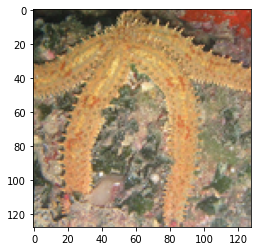

In [31]:
plt.imshow(images_selected_classes[0].transpose(1,2,0))

In [32]:
def get_images_selected_classes_alt():
  airplane_indices, automobile_indices, cat_indices, dog_indices = [], [], [], []
  airplane_idx, automobile_idx, cat_idx, dog_idx = train_data.class_to_idx['airplane'], train_data.class_to_idx['automobile'], train_data.class_to_idx['cat'], train_data.class_to_idx['dog']

  i = 0
  while(len(airplane_indices) < 10 or len(automobile_indices) < 10 or len(cat_indices) < 10 or len(dog_indices) < 10):
      current_class = train_data[i][1]
      if current_class == airplane_idx:
          airplane_indices.append(i)
      elif current_class == automobile_idx:
          automobile_indices.append(i)
      elif current_class == cat_idx:
          cat_indices.append(i)
      elif current_class == dog_idx:
          dog_indices.append(i)
      i += 1

  airplane_indices = airplane_indices[0:10]
  automobile_indices = automobile_indices[0:10]
  cat_indices = cat_indices[0:10]
  dog_indices = dog_indices[0:10]
  selected_train_data = Subset(train_data, airplane_indices + automobile_indices + cat_indices + dog_indices)
  n_images = 40
  cat_indices = []
  cat_idx = train_data.class_to_idx['cat']

  i = 0
  while( len(cat_indices) < n_images ):
      current_class = train_data[i][1]
      if current_class == cat_idx:
          cat_indices.append(i)
      i += 1
  cat_indices = cat_indices[0:n_images]
  selected_train_data = Subset(train_data, cat_indices)
  
  # get some random training images
  trainloader_images_selected_classes = torch.utils.data.DataLoader(selected_train_data, batch_size=n_images, shuffle=False, num_workers=2)
  dataiter_images_selected_classes = iter(trainloader_images_selected_classes)
  images_selected_classes, labels_selected_classes = dataiter_images_selected_classes.next()
  
  return images_selected_classes

## Save and load .mat data for TCA:

In [33]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max_indices = show_stimuli_3D(AlexNet_Model_epoch10, ['conv_layer1'], images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images)

torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])
torch.Size([1024, 11, 11, 32])


In [34]:
neuron_labels.shape

(605,)

In [ ]:
neuron_output_highest_with_shifts.shape

##  (n_images (include all shifts of all images), n_max_feature_maps, #neurons)

(10, 1024, 605)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
from scipy.io import savemat
mdic = {"neuron_output_3D": data}
mdic
savemat("neuron_output_3D_epoch10_max_conv1.mat", mdic)

In [ ]:
data.shape

(605, 10, 1024)

In [ ]:
max_indices

tensor([27,  7, 13, 12, 22])

In [ ]:
data.min()

0.0

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli_3D(AlexNet_Model_epoch10, ['conv_layer1'], images_selected_classes, shifts = True,  max_indices = max_indices, n_images_selected_classes = num_images)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
mdic
savemat("neuron_output_3D_epoch10_fix_conv1.mat", mdic)

In [ ]:
data.shape

(605, 10, 1024)

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli_3D(AlexNet_Model_epoch12, ['conv_layer1'], images_selected_classes, shifts = True,  max_indices = max_indices, n_images_selected_classes = num_images)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
mdic
savemat("neuron_output_3D_epoch12_fix_conv1.mat", mdic)

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli_3D(AlexNet_Model_epoch7, ['conv_layer1'], images_selected_classes, shifts = True,  max_indices = max_indices, n_images_selected_classes = num_images)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
mdic
savemat("neuron_output_3D_epoch7_fix_conv1.mat", mdic)

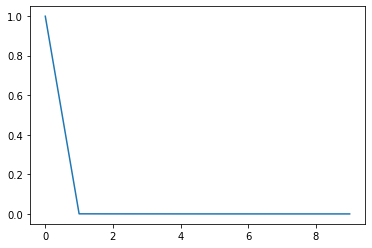

In [ ]:
F = loadmat('factors_opt_nonneg_3D_epoch7.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape
vectors, lambdas = pca.components_, pca.explained_variance_
plt.plot(pca.explained_variance_ratio_)

## Zoom in to one cluster and color by position:

1. use these same plots, to show positional coordinates
2. repeat training with no shifts 
(but compute activcations with shifts to create tensors - use shift step 4)
  - 3d tensor --> run embeddings 
  (array too large even for 20 images)
  - 2d tensor (3rd dim averaged) --> run embeddings (should produce tighter clusters)

3. try bigger images (e.g. cropping imagenet)

In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[0:121]
neuron_label1 = neuron_labels[0:121]

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [ ]:
neuron_cluster1.shape

(121, 10)

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))

In [ ]:
xs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10])

In [ ]:
ys

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10])

In [ ]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color[:,0:3])
    return Z_color

In [ ]:
## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

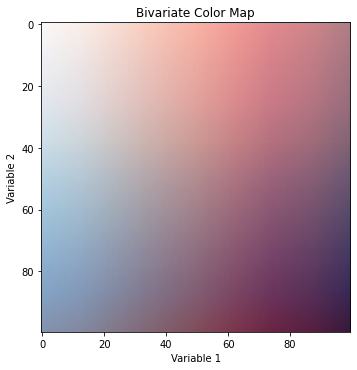

In [ ]:
def colorFromBivariateData_plot(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color

z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData_plot(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData_plot(xx,yy)

fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()

In [ ]:
color_result = colorFromBivariateData(xs,ys)
color_result.shape

(121, 3)

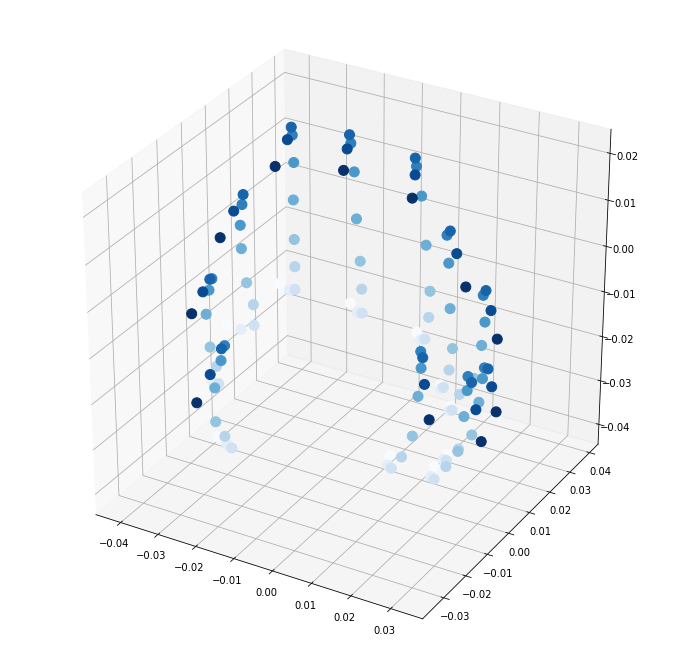

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

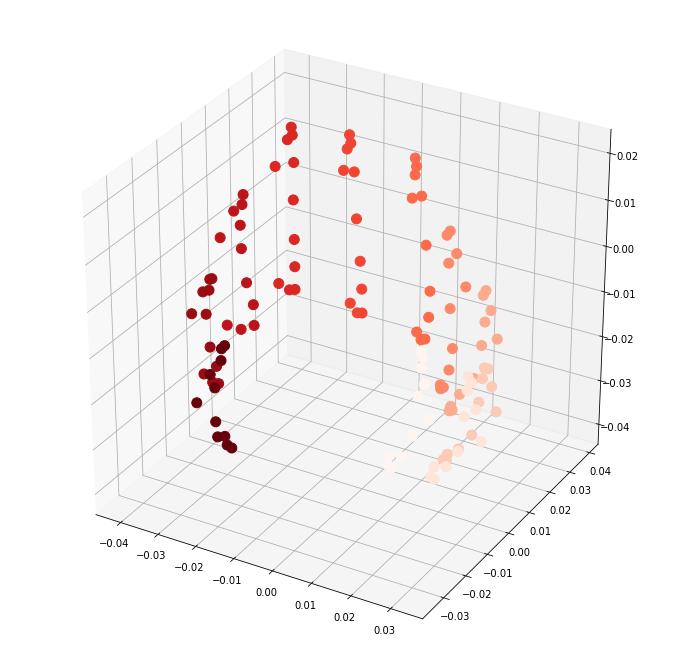

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

# Visualizing embeddings (2D tensor):

In [ ]:
def compute_neuron_output_alt_2D(model, layer_names, images, max10_indices = None):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        images: a tensor of images (stimuli)
    return:
        
    '''
    n_images = images.shape[0]
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    images = images.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_images):
            im = images[i]
            im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
            output = LayerGetter(im)[layer_name] 
            relu = torch.nn.ReLU()
            output = relu(output)
            neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))

        neuron_output = neuron_output.permute(0, 2, 3, 1)
        
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        neuron_output = neuron_output[:,2:(n_row-2),2:(n_col-2),:]
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_images):
        if max10_indices is None:
            max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
            
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

    for i in range(10):    
        neuron_labels += [i] * n_neurons

    neuron_labels = np.array(neuron_labels)  


    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices

In [ ]:
def show_stimuli_2D(model, layer_names, images_selected_classes, shifts, max10_indices, shift_step = 4, n_images_selected_classes = 40):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''


    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt_2D(model, layer_names, images_selected_classes, max10_indices = max10_indices)
  
    else: 
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            ## DEBUG NOTE: since the images need to be resized to 224x224, shift_step should be larger to prevent crashes
            im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)

            im_all_shifts = torch.Tensor(im_all_shifts)
            
            ## neuron_output_highest is of shape (number of shifts, neurons)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt_2D(model, layer_names, im_all_shifts, max10_indices = max10_indices)
             
            if shifts is False:
                neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt_2D(model, layer_names, images_selected_classes, max10_indices = max10_indices)
    
            else:
                # generate shifts for each selected image: 
                neuron_output_highest_with_shifts = []
                fm_avg_all_layers_with_shifts = []
                for i in range(n_images_selected_classes):
                    im = images_selected_classes[i]
                    im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)
                    im_all_shifts = torch.Tensor(im_all_shifts)

                    ## neuron_output_highest is of shape (number of shifts, neurons)
                    neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt_2D(model, layer_names, im_all_shifts, max10_indices = max10_indices)
                  
                    ## take the average over all shifts of im
                    shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
                    shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
                  
                    fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
                    fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
                  
                    if i == 0:
                        neuron_output_highest_with_shifts = shifts_avg 
                        fm_avg_all_layers_with_shifts = fm_shifts_avg
                    else:
                        neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                        fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                      
                neuron_output_highest = neuron_output_highest_with_shifts
                fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices

In [ ]:
images_selected_classes = get_images_selected_classes()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


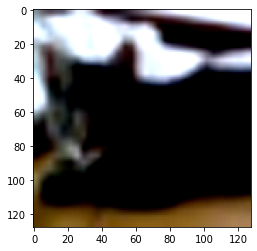

In [ ]:
imshow(images_selected_classes[0])

In [ ]:
max10_indices = torch.tensor([27, 24, 25,  3, 18, 11, 13, 22,  7, 12]) ## from max10 in epoch16

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli_2D(AlexNet_Model_epoch0, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
neuron_output_highest_with_shifts.shape

(40, 1210)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))

In [ ]:
data.shape

(1210, 40)

In [ ]:
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic
savemat("neuron_output_2D_epoch0_fix_debugged.mat", mdic)